# Kaggle 데이터를 활용한 주식 매수 매도 시점 예측

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import xlrd   # pd.read_xlsx
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings(action='ignore')

In [65]:
abd = pd.read_csv('C:/data/spanish_stocks/acs.csv')
abd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2605 non-null   object 
 1   Close   2605 non-null   float64
 2   High    2605 non-null   float64
 3   Low     2605 non-null   float64
 4   Open    2605 non-null   float64
 5   Volume  2605 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 122.2+ KB


In [66]:
abd

,Date,Close,High,Low,Open,Volume
0,2009-02-11,33.72,33.72,33.58,33.67,0
1,2009-02-12,33.10,33.72,33.10,33.65,0
2,2009-02-13,34.74,34.74,33.67,33.67,0
3,2009-02-16,33.51,34.56,33.51,34.31,0
4,2009-02-17,33.30,34.00,33.30,33.64,0
...,...,...,...,...,...,...
2600,2019-06-03,36.77,36.77,36.18,36.72,545790
2601,2019-06-04,37.25,37.45,36.39,36.49,722980
2602,2019-06-05,37.40,37.77,37.23,37.45,1500000
2603,2019-06-06,37.19,37.82,37.05,37.58,633910


In [67]:
abd.isnull().sum() #결측치 없음

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

# 외부변수 생성 - 거시경제변수(금리,환율,유가) / 경기선행지수

In [68]:
# 금리 데이터
# https://www.macrotrends.net/2015/fed-funds-rate-historical-chart
fedint = pd.read_csv('C:/data/fed-funds-rate-historical-chart.csv')
fedint.head()

,Date,value
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88


In [69]:
# 금리 데이터 병합
abd2 = pd.merge(abd, fedint, how='left', left_on='Date', right_on='Date')
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2604
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2605 non-null   object 
 1   Close   2605 non-null   float64
 2   High    2605 non-null   float64
 3   Low     2605 non-null   float64
 4   Open    2605 non-null   float64
 5   Volume  2605 non-null   int64  
 6    value  2593 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 162.8+ KB


In [70]:
# 컬럼명 변경
abd2.rename(columns={' value': 'interest', 'Mean TemperatureC':'temp', ' Mean Humidity':"hum",
                     ' Mean Sea Level PressurehPa':'sealevel', ' Mean Wind SpeedKm/h':'windspeed',
                     'Precipitationmm':'precipitation'}, inplace = True)
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2604
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2605 non-null   object 
 1   Close     2605 non-null   float64
 2   High      2605 non-null   float64
 3   Low       2605 non-null   float64
 4   Open      2605 non-null   float64
 5   Volume    2605 non-null   int64  
 6   interest  2593 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 162.8+ KB


In [71]:
# 금리 결측치 확인
abd2.isnull().sum()

Date         0
Close        0
High         0
Low          0
Open         0
Volume       0
interest    12
dtype: int64

In [72]:
# fed 금리 결측인 행 추출
abd2[abd2['interest'].isnull() == True]

,Date,Close,High,Low,Open,Volume,interest
2215,2017-11-23,31.99,32.16,31.87,32.03,315020,NaN
2249,2018-01-15,32.34,32.55,32.21,32.53,716890,NaN
2274,2018-02-19,27.52,27.89,27.40,27.89,632660,NaN
2341,2018-05-28,34.56,34.95,34.53,34.65,744640,NaN
2368,2018-07-04,34.37,34.46,33.94,34.31,3130000,NaN
2411,2018-09-03,35.39,35.67,35.24,35.44,308550,NaN
2436,2018-10-08,35.40,36.00,35.37,35.41,378070,NaN
2461,2018-11-12,34.22,34.86,34.08,34.57,609320,NaN
2469,2018-11-22,32.87,33.29,32.83,33.03,579410,NaN
2508,2019-01-21,35.00,35.26,34.73,35.08,630040,NaN


In [73]:
# 환율 데이터
# https://www.federalreserve.gov/releases/h10/hist/default.htm
exchange = pd.read_csv('C:/data/FRB_H10.csv')
exchange.head()

,Time Period,exch
0,2009-02-11,1.2893
1,2009-02-12,1.2822
2,2009-02-13,1.2879
3,2009-02-16,ND
4,2009-02-17,1.2571


In [74]:
# 환율 데이터 병합
abd2 = pd.merge(abd2, exchange, how='left', left_on='Date', right_on='Time Period')
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2604
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2605 non-null   object 
 1   Close        2605 non-null   float64
 2   High         2605 non-null   float64
 3   Low          2605 non-null   float64
 4   Open         2605 non-null   float64
 5   Volume       2605 non-null   int64  
 6   interest     2593 non-null   float64
 7   Time Period  2605 non-null   object 
 8   exch         2605 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 203.5+ KB


In [75]:
# Time Period 열 드롭
abd2.drop(['Time Period'], axis=1, inplace=True)
abd2

,Date,Close,High,Low,Open,Volume,interest,exch
0,2009-02-11,33.72,33.72,33.58,33.67,0,0.22,1.2893
1,2009-02-12,33.10,33.72,33.10,33.65,0,0.23,1.2822
2,2009-02-13,34.74,34.74,33.67,33.67,0,0.22,1.2879
3,2009-02-16,33.51,34.56,33.51,34.31,0,0.22,ND
4,2009-02-17,33.30,34.00,33.30,33.64,0,0.25,1.2571
...,...,...,...,...,...,...,...,...
2600,2019-06-03,36.77,36.77,36.18,36.72,545790,2.38,1.1206
2601,2019-06-04,37.25,37.45,36.39,36.49,722980,2.38,1.1236
2602,2019-06-05,37.40,37.77,37.23,37.45,1500000,2.38,1.1242
2603,2019-06-06,37.19,37.82,37.05,37.58,633910,2.37,1.1294


In [76]:
# 환율 ND -> NaN으로 대체
abd2.exch[abd2['exch'] == 'ND'] = float('nan')
abd2

,Date,Close,High,Low,Open,Volume,interest,exch
0,2009-02-11,33.72,33.72,33.58,33.67,0,0.22,1.2893
1,2009-02-12,33.10,33.72,33.10,33.65,0,0.23,1.2822
2,2009-02-13,34.74,34.74,33.67,33.67,0,0.22,1.2879
3,2009-02-16,33.51,34.56,33.51,34.31,0,0.22,NaN
4,2009-02-17,33.30,34.00,33.30,33.64,0,0.25,1.2571
...,...,...,...,...,...,...,...,...
2600,2019-06-03,36.77,36.77,36.18,36.72,545790,2.38,1.1206
2601,2019-06-04,37.25,37.45,36.39,36.49,722980,2.38,1.1236
2602,2019-06-05,37.40,37.77,37.23,37.45,1500000,2.38,1.1242
2603,2019-06-06,37.19,37.82,37.05,37.58,633910,2.37,1.1294


In [77]:
# exch 변수 object -> float 변경
abd2["exch"] = abd2.exch.astype(float)
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2604
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2605 non-null   object 
 1   Close     2605 non-null   float64
 2   High      2605 non-null   float64
 3   Low       2605 non-null   float64
 4   Open      2605 non-null   float64
 5   Volume    2605 non-null   int64  
 6   interest  2593 non-null   float64
 7   exch      2517 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 183.2+ KB


In [78]:
# 환율 데이터 결측치 확인
abd2.isnull().sum()

Date         0
Close        0
High         0
Low          0
Open         0
Volume       0
interest    12
exch        88
dtype: int64

In [79]:
# 국제유가지수(WTI) 데이터
# http://www.itstat.go.kr/stat.it?no=1072&dateType=TMSRES_003&startYear=2009&startMonth=2&startDay=2&endYear=2019&endMonth=6&endDay=28&x=21&y=13
wti = pd.read_excel('C:/data/ITSTAT.xlsx')
wti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  0 non-null      float64
 1   Unnamed: 1  0 non-null      float64
 2   Unnamed: 2  2554 non-null   object 
 3   Unnamed: 3  2554 non-null   object 
dtypes: float64(2), object(2)
memory usage: 80.0+ KB


In [80]:
wti.drop(['Unnamed: 0','Unnamed: 1'], axis=1, inplace=True)
wti = wti.iloc[3:]
wti.rename(columns={'Unnamed: 2':'Date', 'Unnamed: 3':'WTI'}, inplace=True)
wti = wti.reset_index(drop=True)
wti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553 entries, 0 to 2552
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2553 non-null   object
 1   WTI     2553 non-null   object
dtypes: object(2)
memory usage: 40.0+ KB


In [81]:
# Date 시간 버리기
wti['Date'] = pd.to_datetime(wti['Date'], format="%Y-%d-%m")
wti

,Date,WTI
0,2009-02-02,40.08
1,2009-02-03,40.78
2,2009-02-04,40.32
3,2009-02-05,41.17
4,2009-02-06,40.17
...,...,...
2548,2019-06-24,57.90
2549,2019-06-25,57.83
2550,2019-06-26,59.38
2551,2019-06-27,59.43


In [82]:
# wti의 Date 형식 datetime64[ns] => object로 변경
wti.Date = wti.Date.astype(str)

In [83]:
# WTI 데이터 병합
abd2 = pd.merge(abd2, wti, how='left', left_on='Date', right_on='Date')
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2604
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2605 non-null   object 
 1   Close     2605 non-null   float64
 2   High      2605 non-null   float64
 3   Low       2605 non-null   float64
 4   Open      2605 non-null   float64
 5   Volume    2605 non-null   int64  
 6   interest  2593 non-null   float64
 7   exch      2517 non-null   float64
 8   WTI       2469 non-null   object 
dtypes: float64(6), int64(1), object(2)
memory usage: 203.5+ KB


In [84]:
# WTI 컬럼 object => float로 변경
abd2["WTI"] = abd2.WTI.astype(float)
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2604
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2605 non-null   object 
 1   Close     2605 non-null   float64
 2   High      2605 non-null   float64
 3   Low       2605 non-null   float64
 4   Open      2605 non-null   float64
 5   Volume    2605 non-null   int64  
 6   interest  2593 non-null   float64
 7   exch      2517 non-null   float64
 8   WTI       2469 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 203.5+ KB


In [85]:
# 결측치 개수 확인
abd2.isnull().sum()

Date          0
Close         0
High          0
Low           0
Open          0
Volume        0
interest     12
exch         88
WTI         136
dtype: int64

In [86]:
abd2[abd2['WTI'].isnull() == True]

,Date,Close,High,Low,Open,Volume,interest,exch,WTI
3,2009-02-16,33.51,34.56,33.51,34.31,0,0.22,NaN,NaN
51,2009-05-25,37.38,37.38,36.78,37.05,0,0.17,NaN,NaN
71,2009-07-03,34.40,34.86,34.40,34.85,0,0.16,1.3991,NaN
116,2009-09-07,35.60,35.79,35.03,35.34,0,0.15,NaN,NaN
174,2009-11-26,33.50,34.07,33.18,33.88,0,0.11,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2368,2018-07-04,34.37,34.46,33.94,34.31,3130000,NaN,NaN,NaN
2411,2018-09-03,35.39,35.67,35.24,35.44,308550,NaN,NaN,NaN
2469,2018-11-22,32.87,33.29,32.83,33.03,579410,NaN,NaN,NaN
2508,2019-01-21,35.00,35.26,34.73,35.08,630040,NaN,NaN,NaN


In [87]:
# OECD 경기선행지수(CLI; composite leading indicator) 데이터
# https://data.oecd.org/leadind/composite-leading-indicator-cli.htm
cli = pd.read_csv('C:/data/DP_LIVE_23112020061522848.csv')
cli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    125 non-null    object 
 1   CLI     125 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB


In [88]:
# 년도,월 추출 컬럼 생성
cli['Date2'] = cli['Date'].str[:-3]
abd2['Date2'] = abd2['Date'].str[:-3]

In [89]:
# CLI 데이터 병합
abd2 = pd.merge(abd2, cli, how='left', left_on='Date2', right_on='Date2')
abd2.drop(['Date2','Date_y'],axis=1,inplace=True)
abd2.rename(columns={'Date_x':'Date'}, inplace=True)
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2604
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2605 non-null   object 
 1   Close     2605 non-null   float64
 2   High      2605 non-null   float64
 3   Low       2605 non-null   float64
 4   Open      2605 non-null   float64
 5   Volume    2605 non-null   int64  
 6   interest  2593 non-null   float64
 7   exch      2517 non-null   float64
 8   WTI       2469 non-null   float64
 9   CLI       2605 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 223.9+ KB


In [90]:
# cli 결측치 확인
abd2.isnull().sum()

Date          0
Close         0
High          0
Low           0
Open          0
Volume        0
interest     12
exch         88
WTI         136
CLI           0
dtype: int64

In [91]:
abd2.head(20)

,Date,Close,High,Low,Open,Volume,interest,exch,WTI,CLI
0,2009-02-11,33.72,33.72,33.58,33.67,0,0.22,1.2893,35.94,94.77582
1,2009-02-12,33.10,33.72,33.10,33.65,0,0.23,1.2822,33.98,94.77582
2,2009-02-13,34.74,34.74,33.67,33.67,0,0.22,1.2879,37.51,94.77582
3,2009-02-16,33.51,34.56,33.51,34.31,0,0.22,NaN,NaN,94.77582
4,2009-02-17,33.30,34.00,33.30,33.64,0,0.25,1.2571,34.93,94.77582
5,2009-02-18,33.86,33.86,32.94,33.46,0,0.23,1.2547,34.62,94.77582
6,2009-02-19,33.22,33.93,33.22,33.84,0,0.21,1.2675,39.48,94.77582
7,2009-02-20,33.36,33.36,32.50,32.97,0,0.20,1.2690,38.94,94.77582
8,2009-02-25,31.98,32.87,31.98,32.52,0,0.21,1.2731,42.50,94.77582
9,2009-02-26,32.70,32.70,31.90,31.90,0,0.22,1.2764,45.22,94.77582


# 파생변수 생성 - 기술적 지표

### 추세지표: SMA, EMA, Momentum, MACD, Stochastic OSC, CCI

In [92]:
# SMA (종가)
def SMA(df, n1=20, n2=60, n3=120, n4=240):
    df['sma20'] = df['Close'].rolling(n1).mean()  # 4주
    #df['sma20'] = df['sma20'].where(df['sma20'].isnull() == False, df['Close'])

    df['sma60'] = df['Close'].rolling(n2).mean()  # 분기
    #df['sma60'] = df['sma60'].where(df['sma60'].isnull() == False, df['Close'])
    
SMA(abd2)

In [93]:
# EMA (종가)
def EMA(df, n1=20, n2=60, n3=120, n4=240):
    df['ema20'] = df['Close'].ewm(n1).mean()  # 4주
    #df['ema20'] = df['ema20'].where(df['ema20'].isnull() == False, df['Close'])

    df['ema60'] = df['Close'].ewm(n2).mean()  # 분기
    #df['ema60'] = df['ema60'].where(df['ema60'].isnull() == False, df['Close'])
    
EMA(abd2)

In [94]:
# Momentum (종가)
# 단, 금일이 아닌 1일전 종가 사용 / 기간 = 10일 사용
def MOM(df):
    df['mom'] = float('nan')
    for i in range(10,len(df)-1):
        df['mom'].iloc[i+1] = (df['Close'].iloc[i] / df['Close'].iloc[i-10]) * 100
        #df['mom'] = df['mom'].where(df['mom'].isnull() == False, df['Close'])

MOM(abd2)

In [95]:
abd2

,Date,Close,High,Low,Open,Volume,interest,exch,WTI,CLI,sma20,sma60,ema20,ema60,mom
0,2009-02-11,33.72,33.72,33.58,33.67,0,0.22,1.2893,35.94,94.77582,NaN,NaN,33.720000,33.720000,NaN
1,2009-02-12,33.10,33.72,33.10,33.65,0,0.23,1.2822,33.98,94.77582,NaN,NaN,33.402439,33.407438,NaN
2,2009-02-13,34.74,34.74,33.67,33.67,0,0.22,1.2879,37.51,94.77582,NaN,NaN,33.870214,33.858987,NaN
3,2009-02-16,33.51,34.56,33.51,34.31,0,0.22,NaN,NaN,94.77582,NaN,NaN,33.773467,33.769566,NaN
4,2009-02-17,33.30,34.00,33.30,33.64,0,0.25,1.2571,34.93,94.77582,NaN,NaN,33.669315,33.672522,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,2019-06-03,36.77,36.77,36.18,36.72,545790,2.38,1.1206,53.25,101.54880,37.4920,38.936833,38.221918,37.436791,97.929936
2601,2019-06-04,37.25,37.45,36.39,36.49,722980,2.38,1.1236,53.48,101.54880,37.4350,38.902000,38.175637,37.433729,97.429783
2602,2019-06-05,37.40,37.77,37.23,37.45,1500000,2.38,1.1242,51.68,101.54880,37.4165,38.885667,38.138701,37.433176,97.436568
2603,2019-06-06,37.19,37.82,37.05,37.58,633910,2.37,1.1294,52.59,101.54880,37.4230,38.860833,38.093525,37.429189,97.777778


In [96]:
# MACD (종가)
def MACD(df, short=12, long=26, sign=9):
    df['macd'] = df['Close'].ewm(span=short).mean() - df['Close'].ewm(span=long).mean()
    #df['macd'] = df['macd'].where(df['macd'].isnull() == False, df['Close'])

MACD(abd2)

In [97]:
# Stochastic OSC (종가, low, high)
# 금일이 아닌 1일전 종가 사용
# Fast %K = ((전날가 - n기간 중 최저가) / (n기간 중 최고가 - n기간 중 최저가)) * 100
def stochastic(df, n1=14, n2=5, n3=3):
    df['fast_k'] = float('nan')
    for i in range(14,len(df)-1):
        df['fast_k'].iloc[i+1] = ((df['Close'].iloc[i] - df['Low'].iloc[i-14:i].min()) / (df['High'].iloc[i-14:i].max() - df['Low'].iloc[i-14:i].min())) * 100
        #df['fast_k'] = df['fast_k'].where(df['fast_k'].isnull() == False, df['Close'])

        # Slow %K = Fast %K의 m기간 이동평균(SMA)
        df['slow_k'] = df['fast_k'].rolling(n2).mean()
        #df['slow_k'] = df['slow_k'].where(df['slow_k'].isnull() == False, df['Close'])

        # Slow %D = Slow %K의 t기간 이동평균(SMA)
        df['slow_d'] = df['slow_k'].rolling(n3).mean()
        #df['slow_d'] = df['slow_d'].where(df['slow_d'].isnull() == False, df['Close'])
    
stochastic(abd2)

In [98]:
# # Stochastic OSC (종가, low, high)
# # Fast %K = ((현재가 - n기간 중 최저가) / (n기간 중 최고가 - n기간 중 최저가)) * 100
# def stochastic(df, n1=14, n2=5, n3=3):
#     df['fast_k'] = ((df['Close'] - df['Low'].rolling(n1).min()) / (df['High'].rolling(n1).max() - df['Low'].rolling(n1).min())) * 100
#     #df['fast_k'] = df['fast_k'].where(df['fast_k'].isnull() == False, df['Close'])
    
#     # Slow %K = Fast %K의 m기간 이동평균(SMA)
#     df['slow_k'] = df['fast_k'].rolling(n2).mean()
#     #df['slow_k'] = df['slow_k'].where(df['slow_k'].isnull() == False, df['Close'])

#     # Slow %D = Slow %K의 t기간 이동평균(SMA)
#     df['slow_d'] = df['slow_k'].rolling(n3).mean()
#     #df['slow_d'] = df['slow_d'].where(df['slow_d'].isnull() == False, df['Close'])
    
# stochastic(abd2)

In [99]:
# CCI (종가, high, low)
# 금일이 아닌 1일전 종가 사용
def CCI(df, n=20):
    M = (df['High'] + df['Low'] + df['Close']) / 3
    Typical_price = M.rolling(n).sum()
    MA = Typical_price.rolling(n).mean()
    df['cci'] = (Typical_price - MA) / (0.015 * (abs(Typical_price - MA).rolling(n).mean()))
    #df['cci'] = df['cci'].where(df['cci'].isnull() == False, M)

CCI(abd2)

### 변동성 지표: RSI, ATR

In [100]:
# RSI (종가)
def RSI(df, n=14):
    U = df['Close'].diff(1).where(df['Close'].diff(1) > 0, 0)
    D = df['Close'].diff(1).where(df['Close'].diff(1) < 0, 0) * (-1)
    AU = U.rolling(n).mean()
    AD = D.rolling(n).mean()
    df['rsi'] = AU / (AD+AU)
    # df['rsi'] = df['rsi'].where(df['rsi'].isnull() == False, df['Close'])

RSI(abd2)

In [101]:
# ATR
def ATR(df, n=14):
    df['tr0'] = float('nan')
    df['tr1'] = float('nan')
    df['tr2'] = float('nan')
    for i in range(len(df)-2):
        df['tr0'].iloc[i+2] = abs(df['High'].iloc[i+1] - df['Low'].iloc[i+1])
        df['tr1'].iloc[i+2] = abs(df['High'].iloc[i+1] - df['Close'].iloc[i])
        df['tr2'].iloc[i+2] = abs(df['Low'].iloc[i+1] - df['Close'].iloc[i])
    
    tr = df[['tr0', 'tr1', 'tr2']].max(axis=1)
    df['atr'] = tr.rolling(n).mean()
    df.drop(['tr0','tr1','tr2'],axis=1,inplace=True)

ATR(abd2)

In [102]:
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 0 to 2604
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2605 non-null   object 
 1   Close     2605 non-null   float64
 2   High      2605 non-null   float64
 3   Low       2605 non-null   float64
 4   Open      2605 non-null   float64
 5   Volume    2605 non-null   int64  
 6   interest  2593 non-null   float64
 7   exch      2517 non-null   float64
 8   WTI       2469 non-null   float64
 9   CLI       2605 non-null   float64
 10  sma20     2586 non-null   float64
 11  sma60     2546 non-null   float64
 12  ema20     2605 non-null   float64
 13  ema60     2605 non-null   float64
 14  mom       2594 non-null   float64
 15  macd      2605 non-null   float64
 16  fast_k    2590 non-null   float64
 17  slow_k    2586 non-null   float64
 18  slow_d    2584 non-null   float64
 19  cci       2548 non-null   float64
 20  rsi       2592 non-null   floa

# 이상치 확인 및 제거

<AxesSubplot:title={'center':'Trend line of Open Price'}, xlabel='Date'>

<Figure size 1440x720 with 0 Axes>

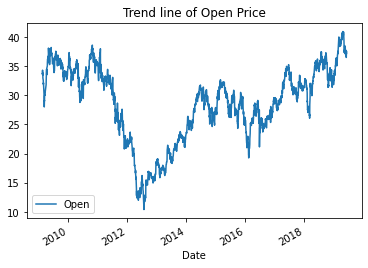

In [103]:
# 이상치 확인 - 시가
new_abd2_o = abd2[['Date','Open']]
new_abd2_o['Date'] = pd.to_datetime(new_abd2_o['Date'])
new_abd2_o = new_abd2_o.set_index('Date')

plt.figure(figsize = (20,10))
new_abd2_o.plot(title = 'Trend line of Open Price')

<AxesSubplot:title={'center':'Trend line of Close Price'}, xlabel='Date'>

<Figure size 1440x720 with 0 Axes>

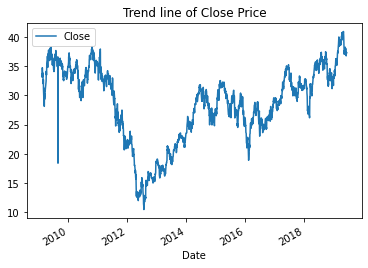

In [104]:
# 이상치 확인 - 종가
new_abd2_c = abd2[['Date','Close']]
new_abd2_c['Date'] = pd.to_datetime(new_abd2_c['Date'])
new_abd2_c = new_abd2_c.set_index('Date')

plt.figure(figsize = (20,10))
new_abd2_c.plot(title = 'Trend line of Close Price')

<AxesSubplot:title={'center':'2009 Trend line of Close Price'}, xlabel='Date'>

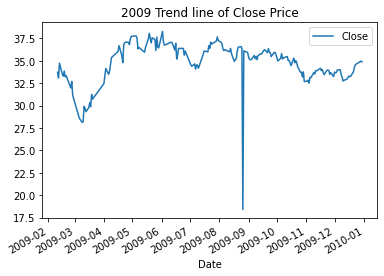

In [105]:
# 이상치 확인
new_abd2_c['2009'].plot(title = '2009 Trend line of Close Price')

In [106]:
# 이상치 제거
new_abd2_o['2009-08']

,Open
Date,
2009-08-03,37.12
2009-08-04,37.06
2009-08-05,37.03
2009-08-06,36.55
2009-08-07,36.06
2009-08-10,36.09
2009-08-11,36.16
2009-08-12,36.04
2009-08-13,36.08


In [107]:
# 이상치 제거
abd2 = abd2[abd2['Date'] != '2009-08-26']
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2604 entries, 0 to 2604
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2604 non-null   object 
 1   Close     2604 non-null   float64
 2   High      2604 non-null   float64
 3   Low       2604 non-null   float64
 4   Open      2604 non-null   float64
 5   Volume    2604 non-null   int64  
 6   interest  2592 non-null   float64
 7   exch      2516 non-null   float64
 8   WTI       2468 non-null   float64
 9   CLI       2604 non-null   float64
 10  sma20     2585 non-null   float64
 11  sma60     2545 non-null   float64
 12  ema20     2604 non-null   float64
 13  ema60     2604 non-null   float64
 14  mom       2593 non-null   float64
 15  macd      2604 non-null   float64
 16  fast_k    2589 non-null   float64
 17  slow_k    2585 non-null   float64
 18  slow_d    2583 non-null   float64
 19  cci       2547 non-null   float64
 20  rsi       2591 non-null   floa

In [108]:
abd2[abd2['Date'] == '2009-08-26'] # 제거됨

,Date,Close,High,Low,Open,Volume,interest,exch,WTI,CLI,...,ema20,ema60,mom,macd,fast_k,slow_k,slow_d,cci,rsi,atr


# 결측치 제거

In [109]:
abd2.isnull().sum()

Date          0
Close         0
High          0
Low           0
Open          0
Volume        0
interest     12
exch         88
WTI         136
CLI           0
sma20        19
sma60        59
ema20         0
ema60         0
mom          11
macd          0
fast_k       15
slow_k       19
slow_d       21
cci          57
rsi          13
atr          15
dtype: int64

In [46]:
# abd2 결측 제거
abd2 = abd2[abd2['exch'].isnull() == False]
abd2 = abd2[abd2['WTI'].isnull() == False]
abd2 = abd2[abd2['sma20'].isnull() == False]
abd2 = abd2[abd2['sma60'].isnull() == False]
abd2 = abd2[abd2['mom'].isnull() == False]
abd2 = abd2[abd2['fast_k'].isnull() == False]
abd2 = abd2[abd2['slow_k'].isnull() == False]
abd2 = abd2[abd2['slow_d'].isnull() == False]
abd2 = abd2[abd2['cci'].isnull() == False]
abd2 = abd2[abd2['atr'].isnull() == False]
abd2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2382 entries, 59 to 2604
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2382 non-null   object 
 1   Close     2382 non-null   float64
 2   High      2382 non-null   float64
 3   Low       2382 non-null   float64
 4   Open      2382 non-null   float64
 5   Volume    2382 non-null   int64  
 6   interest  2382 non-null   float64
 7   exch      2382 non-null   float64
 8   WTI       2382 non-null   float64
 9   CLI       2382 non-null   float64
 10  sma20     2382 non-null   float64
 11  sma60     2382 non-null   float64
 12  ema20     2382 non-null   float64
 13  ema60     2382 non-null   float64
 14  mom       2382 non-null   float64
 15  macd      2382 non-null   float64
 16  fast_k    2382 non-null   float64
 17  slow_k    2382 non-null   float64
 18  slow_d    2382 non-null   float64
 19  cci       2382 non-null   float64
 20  rsi       2382 non-null   flo

In [47]:
abd2.isnull().sum()

Date        0
Close       0
High        0
Low         0
Open        0
Volume      0
interest    0
exch        0
WTI         0
CLI         0
sma20       0
sma60       0
ema20       0
ema60       0
mom         0
macd        0
fast_k      0
slow_k      0
slow_d      0
cci         0
rsi         0
atr         0
dtype: int64

# 모델링 - 다중회귀(+Lasso, Ridge) / RF / GB / LightGBM

In [48]:
# Date, high(최고가), low(최저가), open(시가), volume(거래량) 컬럼 제거
abd2.drop(['Close','High','Low','Open','Volume'], axis=1, inplace=True)

In [49]:
# MAPE
def MAPE(y_true, y_pred):  # mean_absolute_percentage_error
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100 , 2)

In [50]:
# input / target 컬럼 분리
X = abd2.drop(['rsi','Date'], axis=1)
y = abd2.rsi

## 회귀분석

In [51]:
# train / test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [52]:
# 설명변수 정규화
scaler = MinMaxScaler()
X_train[:] = scaler.fit_transform(X_train[:])
X_test[:] = scaler.fit_transform(X_test[:])

In [53]:
# 회귀모형 적합
lm = LinearRegression()
model = lm.fit(X_train, y_train)  # fitted model
y_pred = model.predict(X_test)  # predicted value 

score = lm.score(X_test, y_test)  # r_squred
mape = MAPE(y_test,y_pred)  # MAPE
print(" Linear Regression test accuracy:", str(score), "\n", "MAPE:", str(mape))

 Linear Regression test accuracy: 0.5175789804504611 
 MAPE: 26.85


In [62]:
import statsmodels.api as sm
from scipy import stats

In [63]:
X2 = sm.add_constant(X_train)
OLS = sm.OLS(y_train, X2)
model2 = OLS.fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    rsi   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     607.1
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:48:01   Log-Likelihood:                 2142.2
No. Observations:                1786   AIC:                            -4252.
Df Residuals:                    1770   BIC:                            -4165.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0525      0.018     -2.914      0.0

In [54]:
# 회귀 계수 출력
coef = pd.DataFrame({'coefficients':model.coef_})
cols = pd.DataFrame({'columns':X_train.columns})
coef_table = pd.concat([cols,coef], axis=1)
coef_table

,columns,coefficients
0,interest,-0.009630
1,exch,-0.025957
2,WTI,0.021072
3,CLI,-0.031531
4,sma20,-6.219928
5,sma60,-1.434420
6,ema20,7.967112
7,ema60,-0.519117
8,mom,-0.120268
9,macd,0.778986


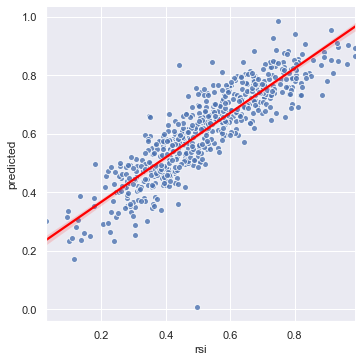

In [55]:
# Scattered plot
testset = pd.DataFrame(y_test).reset_index()
testset.drop('index', axis=1, inplace=True)
predicted_y = pd.DataFrame({'predicted':y_pred})
predicted_table = pd.concat([testset,predicted_y], axis=1)

sns.set(font_scale = 1)
sns.lmplot(x="rsi", y="predicted", data = predicted_table, line_kws={'color':'red'}, scatter_kws={'edgecolor':"white"})

## Lasso

In [141]:
# gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# 파라미터 후보
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.05, 1, 10, 100]}

# 그리드 서치 진행

grid_search = GridSearchCV(Lasso(), param_grid, scoring='neg_root_mean_squared_error', cv=5)        

# 최종 모델 성능 점검
print('The best value of alpha is:', grid_search.fit(X_train, y_train).best_params_)
print('The best score for the best Lasso estimator is:', grid_search.fit(X_test, y_test).best_score_)

The best value of alpha is: {'alpha': 0.0001}
The best score for the best Lasso estimator is: -0.09613030271986793


In [137]:
grid_search.cv_results_

{'mean_fit_time': array([0.04066815, 0.00717063, 0.00484791, 0.00478611, 0.00490003,
        0.00678158, 0.0058403 ]),
 'std_fit_time': array([0.00495642, 0.00262017, 0.00076006, 0.00040225, 0.00114118,
        0.00171615, 0.00076923]),
 'mean_score_time': array([0.00343728, 0.00339265, 0.00284281, 0.00348625, 0.00328674,
        0.004     , 0.00350924]),
 'std_score_time': array([0.00145768, 0.00053312, 0.00016041, 0.00061732, 0.00039101,
        0.00153713, 0.00077809]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.05, 1, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.05},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100}],
 'split0_test_score': array([-0.08034437, -0.08370221, -0.10707148, -0.17762238, -0.17762238,
        -0.17762238, -0.17762238]),
 'split1_test_score': array([-0.07800833, -0.08268704,

In [144]:
# cross validation - rmse 비교
from sklearn.model_selection import cross_val_score

lasso1 = Lasso(alpha=0.0001)
scores1 = cross_val_score(lasso1, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
scores1
np.mean(scores1)

-0.07945891116906544

In [147]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred1, squared=False)

0.10238065578463831

In [148]:
lasso2 = Lasso(alpha=0.001)
scores2 = cross_val_score(lasso2, X_train, y_train, cv=5,  scoring = 'neg_root_mean_squared_error')
scores2
np.mean(scores2)

-0.08348068846780923

In [149]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred2, squared=False)

0.101121299090058

In [151]:
# alpah = [0.0001, 0.001, 0.01, 0.05, 1].
lasso0 = Lasso(alpha=0).fit(X_train, y_train)
lasso1 = Lasso(alpha=0.0001).fit(X_train, y_train)
lasso2 = Lasso(alpha=0.001).fit(X_train, y_train)
lasso3 = Lasso(alpha=0.01).fit(X_train, y_train)
lasso4 = Lasso(alpha=0.05).fit(X_train, y_train)
lasso5 = Lasso(alpha=1).fit(X_train, y_train)

y_pred0 = lasso0.predict(X_test)
y_pred1 = lasso1.predict(X_test)
y_pred2 = lasso2.predict(X_test)
y_pred3 = lasso3.predict(X_test)
y_pred4 = lasso4.predict(X_test)
y_pred5 = lasso5.predict(X_test)

print(' alpha=0.0001:', MAPE(y_test,y_pred1), '\n',
      'alpha=0.001:', MAPE(y_test,y_pred2), '\n',
      'alpha=0.01:', MAPE(y_test,y_pred3), '\n',
      'alpha=0.05:', MAPE(y_test,y_pred4), '\n',
      'alpha=1:', MAPE(y_test,y_pred5))

 alpha=0.0001: 22.49 
 alpha=0.001: 21.89 
 alpha=0.01: 31.88 
 alpha=0.05: 38.29 
 alpha=1: 38.29


In [155]:
lasso2.coef_

array([-0.        ,  0.        ,  0.        , -0.        , -0.00340784,
       -0.        , -0.        , -0.        ,  0.12237926,  0.14417566,
        0.45933526,  0.        ,  0.37543579,  0.        ,  0.        ])

In [158]:
# Lasso 회귀 계수 출력
coef = pd.DataFrame({'coefficients':lasso2.coef_})
cols = pd.DataFrame({'columns':X_train.columns})
coef_table = pd.concat([cols,coef], axis=1)
coef_table = coef_table[coef_table['coefficients'] != 0]
coef_table

,columns,coefficients
4,sma20,-0.003408
8,mom,0.122379
9,macd,0.144176
10,fast_k,0.459335
12,slow_d,0.375436


## Ridge

In [159]:
# gridsearch
from sklearn.model_selection import GridSearchCV

# 파라미터 후보
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.05, 1, 10, 100]}

# 그리드 서치 진행
grid_search = GridSearchCV(Ridge(), param_grid, scoring='neg_root_mean_squared_error', cv=5)        

# 최종 모델 성능 점검
print('The best value of alpha is:', grid_search.fit(X_train, y_train).best_params_)
print('The best score for the best Lasso estimator is:', grid_search.fit(X_test, y_test).best_score_)

The best value of alpha is: {'alpha': 0.0001}
The best score for the best Lasso estimator is: -0.09540212797513388


In [167]:
# alpha = [0.01, 0.1, 0.5, 1, 10, 50, 100]
ridge0 = Ridge(alpha=0).fit(X_train, y_train)
ridge1 = Ridge(alpha=0.2).fit(X_train, y_train)
ridge2 = Ridge(alpha=1).fit(X_train, y_train)
ridge3 = Ridge(alpha=10).fit(X_train, y_train)
ridge4 = Ridge(alpha=50).fit(X_train, y_train)
ridge5 = Ridge(alpha=100).fit(X_train, y_train)

y_pred0 = ridge0.predict(X_test)
y_pred1 = ridge1.predict(X_test)
y_pred2 = ridge2.predict(X_test)
y_pred3 = ridge3.predict(X_test)
y_pred4 = ridge4.predict(X_test)
y_pred5 = ridge5.predict(X_test)

print(' Linear Reg.:', MAPE(y_test,y_pred0), '\n',
      'alpha=0.5:', MAPE(y_test,y_pred1), '\n',
      'alpha=1:', MAPE(y_test,y_pred2), '\n',
      'alpha=10:', MAPE(y_test,y_pred3), '\n',
      'alpha=50:', MAPE(y_test,y_pred4), '\n',
      'alpha=100:', MAPE(y_test,y_pred5))

 Linear Reg.: 26.85 
 alpha=0.5: 18.99 
 alpha=1: 20.2 
 alpha=10: 21.23 
 alpha=50: 21.74 
 alpha=100: 23.41


In [168]:
ridge1.coef_

array([-0.00380763, -0.00503629,  0.01408765, -0.01081321, -1.08230413,
        0.64143492,  0.30417196,  0.05365079,  0.08118382,  0.50478949,
        0.45361096, -0.17378337,  0.41251225, -0.0484447 ,  0.05583776])

In [169]:
# Ridge 회귀 계수 출력
coef = pd.DataFrame({'coefficients':ridge1.coef_})
cols = pd.DataFrame({'columns':X_train.columns})
coef_table = pd.concat([cols,coef], axis=1)
coef_table

,columns,coefficients
0,interest,-0.003808
1,exch,-0.005036
2,WTI,0.014088
3,CLI,-0.010813
4,sma20,-1.082304
5,sma60,0.641435
6,ema20,0.304172
7,ema60,0.053651
8,mom,0.081184
9,macd,0.504789


## Random Forest

In [61]:
# train / test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

### Hyperparameter tuning

In [62]:
# Random Forest
def objective(trial):
       
    param = {'n_estimators' : trial.suggest_int('n_estimators', 50,500),
             'max_depth': trial.suggest_int( 'max_depth', 7, 25),
            }
    
        
    rf = RandomForestRegressor(**param, random_state=100)
                 
    rf_model = rf.fit(X_train, y_train)
    preds = rf_model.predict(X_test)
    
    pred_labels = np.rint(preds)
    #accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    mape = MAPE(y_test, pred_labels)
    return mape

In [63]:
# hyperparameter tuning: Optuna
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
params = study.best_trial.params
print('Best trial:', params)

[I 2020-11-27 02:29:14,423] A new study created in memory with name: no-name-5d045e5a-2359-4fb2-9a1f-14987f4aca03
[I 2020-11-27 02:29:21,209] Trial 0 finished with value: 79.5 and parameters: {'n_estimators': 237, 'max_depth': 17}. Best is trial 0 with value: 79.5.
[I 2020-11-27 02:29:27,663] Trial 1 finished with value: 79.46 and parameters: {'n_estimators': 302, 'max_depth': 11}. Best is trial 1 with value: 79.46.
[I 2020-11-27 02:29:35,650] Trial 2 finished with value: 79.46 and parameters: {'n_estimators': 340, 'max_depth': 17}. Best is trial 1 with value: 79.46.
[I 2020-11-27 02:29:40,417] Trial 3 finished with value: 79.52 and parameters: {'n_estimators': 187, 'max_depth': 9}. Best is trial 1 with value: 79.46.
[I 2020-11-27 02:29:53,733] Trial 4 finished with value: 79.5 and parameters: {'n_estimators': 481, 'max_depth': 25}. Best is trial 1 with value: 79.46.
[I 2020-11-27 02:29:55,884] Trial 5 finished with value: 79.46 and parameters: {'n_estimators': 90, 'max_depth': 25}. Be

Best trial: {'n_estimators': 55, 'max_depth': 15}


In [64]:
rf = RandomForestRegressor(**params, random_state=100)

rf_model = rf.fit(X_train, y_train)  # 모델 적합
y_pred = rf_model.predict(X_test)  # 타겟값 예측
MAPE(y_pred,y_test)
# 12.4

12.4

In [65]:
# 변수 중요도
rf_feature_imp = rf_model.feature_importances_
rf_feature_imp = pd.DataFrame({'Value':rf_feature_imp,'Feature':X_train.columns})
rf_feature_imp_sort = rf_feature_imp.sort_values(by=['Value'], axis=0, ascending=False) # Value_per 내림차순 정렬
rf_feature_imp_sort

,Value,Feature
11,0.538429,slow_k
10,0.215908,fast_k
12,0.072178,slow_d
9,0.031425,macd
8,0.028073,mom
14,0.018618,atr
13,0.014920,cci
3,0.014423,WTI
1,0.012956,exch
5,0.010715,sma60


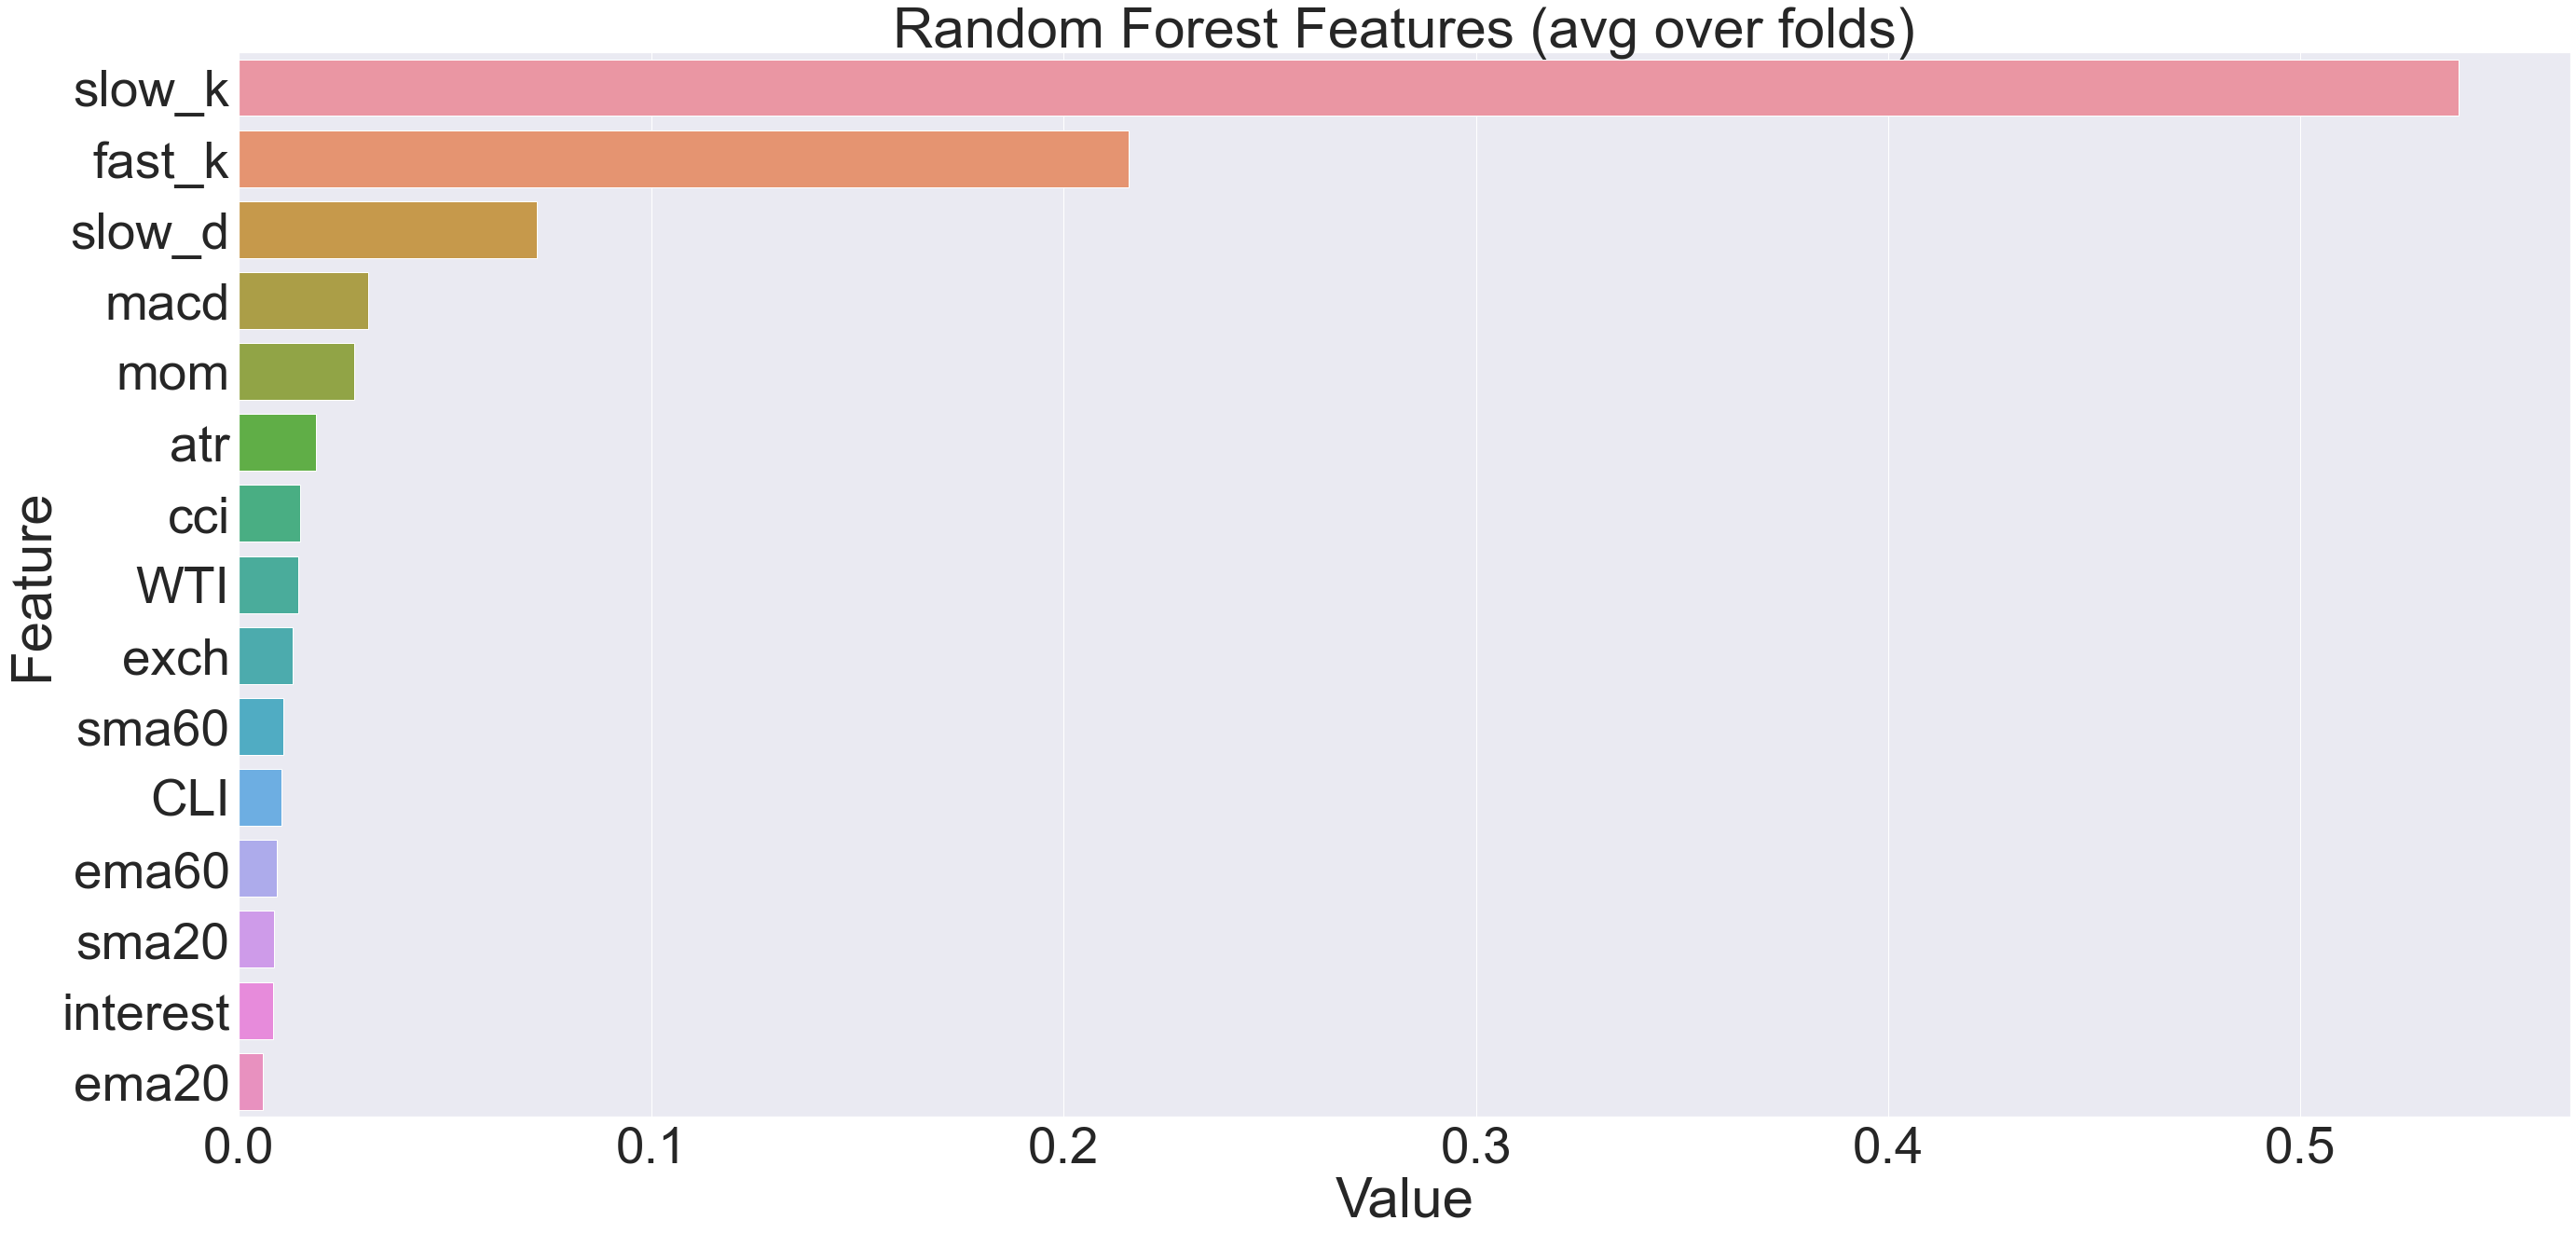

In [66]:
# Feature Importance plot
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=rf_feature_imp_sort)
plt.title('Random Forest Features (avg over folds)')
plt.tight_layout()
plt.show()

## Gradient Boosting

In [67]:
# train / test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [68]:
# Gradient Boosting
def objective(trial):
       
    param = {'n_estimators' : trial.suggest_int('n_estimators', 50,500),
             'max_depth': trial.suggest_int( 'max_depth', 7, 25),
             #'min_samples_split': 5,
             'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.0),
             #'loss': 'ls'
             }
    
        
    gb = GradientBoostingRegressor(**param, random_state=100)
                 
    gb_model = gb.fit(X_train, y_train)
    preds = gb_model.predict(X_test)
    
    pred_labels = np.rint(preds)
    #accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    mape = MAPE(y_test, pred_labels)
    return mape

In [69]:
# hyperparameter tuning: Optuna
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
params = study.best_trial.params
print('Best trial:', params)

[I 2020-11-27 02:34:16,692] A new study created in memory with name: no-name-35cf7468-3ef7-4b84-a29a-7b4616177838
[I 2020-11-27 02:34:22,841] Trial 0 finished with value: 81.35 and parameters: {'n_estimators': 403, 'max_depth': 10, 'learning_rate': 0.9790745091946441}. Best is trial 0 with value: 81.35.
[I 2020-11-27 02:34:29,161] Trial 1 finished with value: 79.82 and parameters: {'n_estimators': 211, 'max_depth': 9, 'learning_rate': 0.20552021354889544}. Best is trial 1 with value: 79.82.
[I 2020-11-27 02:34:39,199] Trial 2 finished with value: 79.92 and parameters: {'n_estimators': 406, 'max_depth': 7, 'learning_rate': 0.41184407295056663}. Best is trial 1 with value: 79.82.
[I 2020-11-27 02:34:48,844] Trial 3 finished with value: 79.11 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.24818513076706217}. Best is trial 3 with value: 79.11.
[I 2020-11-27 02:34:50,798] Trial 4 finished with value: 80.93 and parameters: {'n_estimators': 63, 'max_depth': 17, 'lear

Best trial: {'n_estimators': 398, 'max_depth': 8, 'learning_rate': 0.24608171308011884}


In [70]:
# 모델링
gb = GradientBoostingRegressor(**params, random_state=100)
gb_model = gb.fit(X_train, y_train)  # 모델 적합
y_pred = gb_model.predict(X_test)  # 모델 예측
MAPE(y_pred,y_test)
# 12.12

12.12

In [71]:
# 변수 중요도
gb_feature_imp = gb_model.feature_importances_
gb_feature_imp = pd.DataFrame({'Value':gb_feature_imp,'Feature':X_train.columns})
gb_feature_imp_sort = gb_feature_imp.sort_values(by=['Value'], axis=0, ascending=False) # Value_per 내림차순 정렬
gb_feature_imp_sort

,Value,Feature
11,0.583063,slow_k
10,0.180790,fast_k
12,0.058349,slow_d
9,0.037456,macd
8,0.021152,mom
13,0.018773,cci
14,0.018401,atr
3,0.014940,WTI
1,0.013464,exch
4,0.011231,sma20


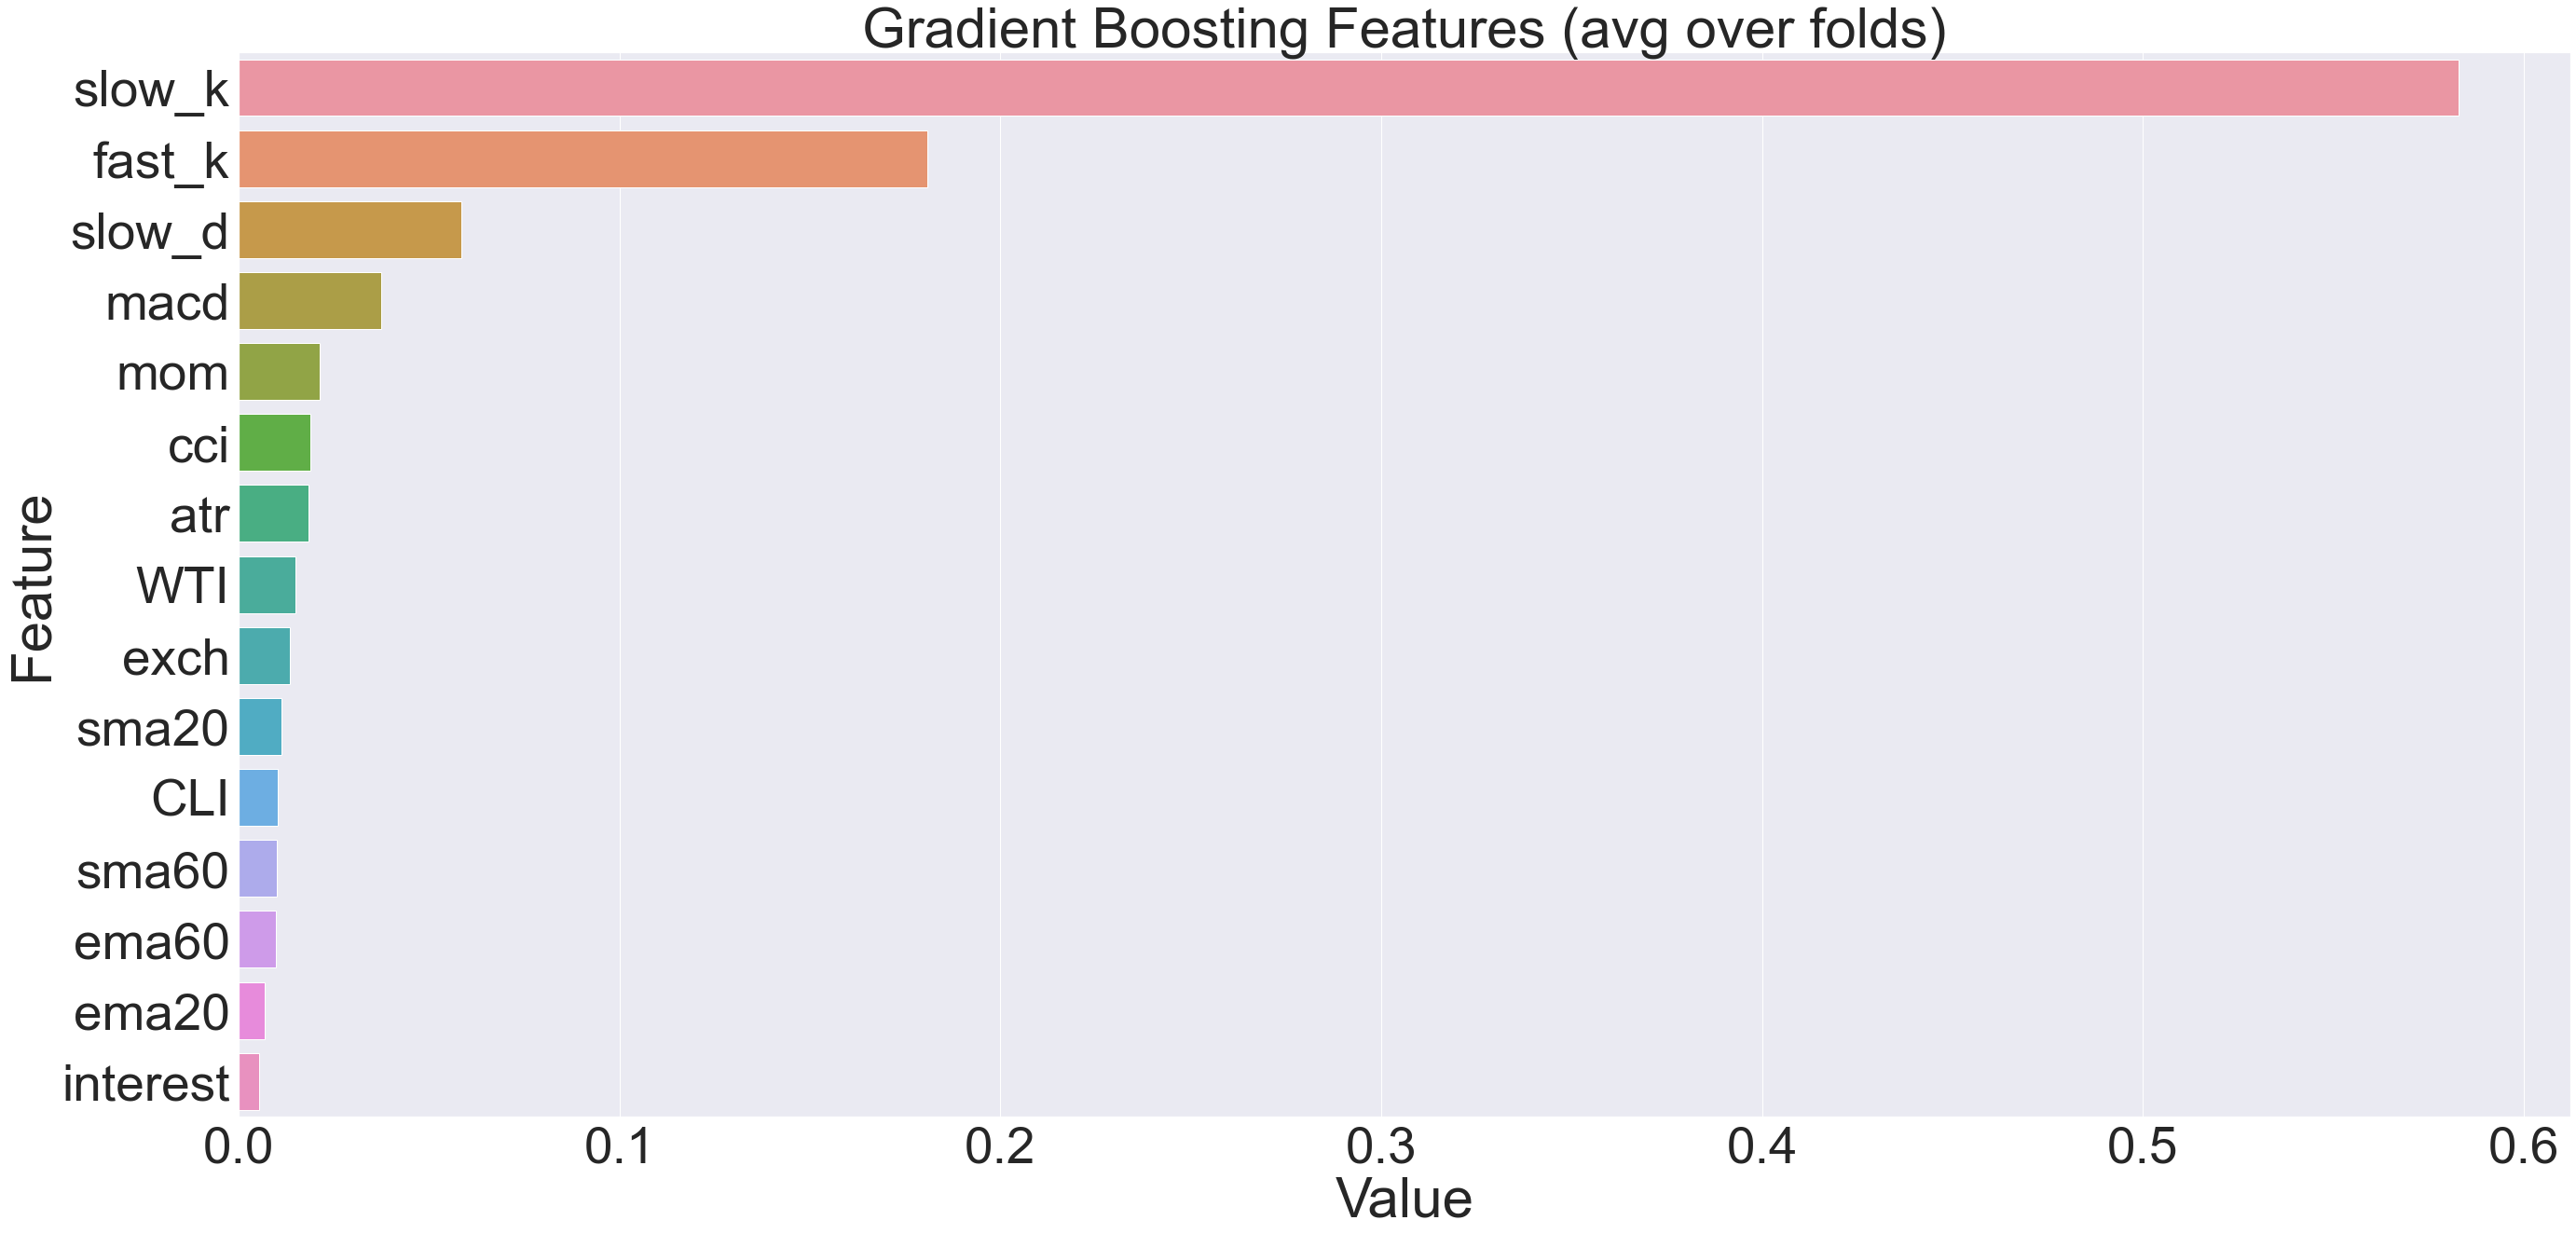

In [72]:
# Feature Importance plot
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=gb_feature_imp_sort)
plt.title('Gradient Boosting Features (avg over folds)')
plt.tight_layout()
plt.show()

## LightGBM

In [73]:
# LightGBM 학습용 데이터셋 제작
d_train = lgb.Dataset(X_train, label = y_train)

In [74]:
# LigthGBM
def objective(trial):
       
    param = {
            'objective' : 'regression',
            'num_leaves': trial.suggest_int('num_leaves', 31, 256),
            #'max_depth' : trial.suggest_int( 'max_depth', 7, 25),        
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'sub_sample' : trial.suggest_uniform('sub_sample',0.4,1.0),
            'boosting' : 'gbdt',
            'feature_pre_filter' : False
            #'n_estimators' : trial.suggest_int('n_estimators', 50,500)
            #'max_depth'
            }
    
    lgb_model = lgb.train(param, d_train,
                   valid_sets = [d_train])
    preds = lgb_model.predict(X_test)
    
    pred_labels = np.rint(preds)
    #accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    mape = MAPE(y_test, pred_labels)
    return mape

In [75]:
# hyperparameter tuning: Optuna
study = optuna.create_study()
study.optimize(objective, n_trials = 100)
params = study.best_trial.params
print('Best trial:', study.best_trial.params)

[I 2020-11-27 02:55:14,346] A new study created in memory with name: no-name-ebda06a3-71c1-40c9-a4a7-53555e8193d4


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0277044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0237171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0203673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0176453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's l2: 0.015438
[LightGBM] [Warning] No further spl

[I 2020-11-27 02:55:15,010] Trial 0 finished with value: 79.34 and parameters: {'num_leaves': 75, 'feature_fraction': 0.8986552953076677, 'bagging_fraction': 0.7778999923889153, 'bagging_freq': 5, 'min_child_samples': 46, 'sub_sample': 0.5544621949194071}. Best is trial 0 with value: 79.34.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00223911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00222393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00220914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00218972
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Wa

[I 2020-11-27 02:55:15,654] Trial 1 finished with value: 79.55 and parameters: {'num_leaves': 122, 'feature_fraction': 0.829722500996412, 'bagging_fraction': 0.7540835101691545, 'bagging_freq': 1, 'min_child_samples': 60, 'sub_sample': 0.4602241938172356}. Best is trial 0 with value: 79.34.


No further splits with positive gain, best gain: -inf
[82]	training's l2: 0.00314235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	training's l2: 0.00312312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	training's l2: 0.0031031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	training's l2: 0.00308513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	training's l2: 0.00306382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	training's l2: 0.0030399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	training's l2: 0.0030262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	training's l2: 0.00300663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	training's l2: 0.00298708
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2020-11-27 02:55:16,154] Trial 2 finished with value: 79.07 and parameters: {'num_leaves': 164, 'feature_fraction': 0.746761166040534, 'bagging_fraction': 0.7828904325284025, 'bagging_freq': 4, 'min_child_samples': 60, 'sub_sample': 0.8122901502021276}. Best is trial 2 with value: 79.07.


No further splits with positive gain, best gain: -inf
[89]	training's l2: 0.00298715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	training's l2: 0.00297086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00295199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00293742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00291915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00290336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00288276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00286548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00284756
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2020-11-27 02:55:16,886] Trial 3 finished with value: 79.33 and parameters: {'num_leaves': 104, 'feature_fraction': 0.8460136168860466, 'bagging_fraction': 0.9949369367123226, 'bagging_freq': 7, 'min_child_samples': 41, 'sub_sample': 0.6513148178135972}. Best is trial 2 with value: 79.07.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00142484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.0014092
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.027693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0236874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	trai

[I 2020-11-27 02:55:17,463] Trial 4 finished with value: 79.17 and parameters: {'num_leaves': 148, 'feature_fraction': 0.7916909230351931, 'bagging_fraction': 0.8181854682440527, 'bagging_freq': 7, 'min_child_samples': 44, 'sub_sample': 0.7017424211352674}. Best is trial 2 with value: 79.07.



[92]	training's l2: 0.00216087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00214429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00212475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00210551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00209185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00207801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00206386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00204285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00202725
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warni

[I 2020-11-27 02:55:18,284] Trial 5 finished with value: 79.24 and parameters: {'num_leaves': 208, 'feature_fraction': 0.8603001484475805, 'bagging_fraction': 0.9111515067937561, 'bagging_freq': 2, 'min_child_samples': 21, 'sub_sample': 0.965247968227961}. Best is trial 2 with value: 79.07.


No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00059904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.000588411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.000577602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.000567112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00055735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.000547951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000537853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000529543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000519497
[LightGBM] [Warning] No further splits with positive gain, b

[I 2020-11-27 02:55:18,807] Trial 6 finished with value: 79.25 and parameters: {'num_leaves': 227, 'feature_fraction': 0.8279489980500444, 'bagging_fraction': 0.7124065282097092, 'bagging_freq': 6, 'min_child_samples': 71, 'sub_sample': 0.6134488572705733}. Best is trial 2 with value: 79.07.


No further splits with positive gain, best gain: -inf
[87]	training's l2: 0.00359951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	training's l2: 0.00358516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	training's l2: 0.0035693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	training's l2: 0.00355161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00353192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00351225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00349775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00348524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00346834
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2020-11-27 02:55:19,526] Trial 7 finished with value: 79.28 and parameters: {'num_leaves': 104, 'feature_fraction': 0.8513558524446743, 'bagging_fraction': 0.8574926541080254, 'bagging_freq': 3, 'min_child_samples': 37, 'sub_sample': 0.5719299111728052}. Best is trial 2 with value: 79.07.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00160852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00159272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00157622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00156231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.0015474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00153421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00151722
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000820 second

[I 2020-11-27 02:55:20,096] Trial 8 finished with value: 79.39 and parameters: {'num_leaves': 237, 'feature_fraction': 0.7248816965636632, 'bagging_fraction': 0.9586801285447382, 'bagging_freq': 5, 'min_child_samples': 58, 'sub_sample': 0.4371587120008287}. Best is trial 2 with value: 79.07.


[89]	training's l2: 0.00248353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	training's l2: 0.0024668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00244359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.0024231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00240655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00238871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00237159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00235447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00233693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00231933
[LightGBM] [Warni

[I 2020-11-27 02:55:20,507] Trial 9 finished with value: 79.61 and parameters: {'num_leaves': 99, 'feature_fraction': 0.7754032636126791, 'bagging_fraction': 0.7884451946535159, 'bagging_freq': 6, 'min_child_samples': 97, 'sub_sample': 0.5622454328469535}. Best is trial 2 with value: 79.07.


[70]	training's l2: 0.00431421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	training's l2: 0.00429198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	training's l2: 0.00427149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	training's l2: 0.0042524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	training's l2: 0.00423318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	training's l2: 0.0042083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	training's l2: 0.00419382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	training's l2: 0.00417188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	training's l2: 0.00415969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	training's l2: 0.00414362
[LightGBM] [Warni

[I 2020-11-27 02:55:20,994] Trial 10 finished with value: 79.57 and parameters: {'num_leaves': 166, 'feature_fraction': 0.7074275221521398, 'bagging_fraction': 0.7108619489032315, 'bagging_freq': 3, 'min_child_samples': 86, 'sub_sample': 0.8731337036546013}. Best is trial 2 with value: 79.07.



[98]	training's l2: 0.00386622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00385077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.003834
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0232782
[LightGBM] [Warning] No further splits with positive

[I 2020-11-27 02:55:22,036] Trial 11 finished with value: 79.02 and parameters: {'num_leaves': 171, 'feature_fraction': 0.7667331471383745, 'bagging_fraction': 0.8364451800196337, 'bagging_freq': 7, 'min_child_samples': 19, 'sub_sample': 0.7946487167356203}. Best is trial 11 with value: 79.02.


No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000585191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000574177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000561781
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[1]	training's l2: 0.0269954
[2]	training's l2: 0.0223675
[3]	training's l2: 0.0185749
[4]	training's l2: 0.0154847
[5]	training's l2: 0.0129004
[6]	training's l2: 0.0107943
[7]	training's l2: 0.0090845

[I 2020-11-27 02:55:24,395] Trial 12 finished with value: 79.18 and parameters: {'num_leaves': 180, 'feature_fraction': 0.9949403419803641, 'bagging_fraction': 0.8653158281941624, 'bagging_freq': 4, 'min_child_samples': 5, 'sub_sample': 0.7988437100812876}. Best is trial 11 with value: 79.02.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0233579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0198638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0170036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:25,476] Trial 13 finished with value: 79.34 and parameters: {'num_leaves': 187, 'feature_fraction': 0.7500580542894413, 'bagging_fraction': 0.8252000601024596, 'bagging_freq': 1, 'min_child_samples': 20, 'sub_sample': 0.7874151138346973}. Best is trial 11 with value: 79.02.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0277969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0238826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0206147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0179014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:26,105] Trial 14 finished with value: 79.36 and parameters: {'num_leaves': 41, 'feature_fraction': 0.7077267358973954, 'bagging_fraction': 0.9002080804849589, 'bagging_freq': 4, 'min_child_samples': 77, 'sub_sample': 0.9727834145025527}. Best is trial 11 with value: 79.02.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0234018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0170971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:27,335] Trial 15 finished with value: 78.98 and parameters: {'num_leaves': 150, 'feature_fraction': 0.7753242282874885, 'bagging_fraction': 0.7518230477486365, 'bagging_freq': 6, 'min_child_samples': 20, 'sub_sample': 0.8809228676894464}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0270425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0225358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0187976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0157475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:31,013] Trial 16 finished with value: 79.28 and parameters: {'num_leaves': 255, 'feature_fraction': 0.7820505469728763, 'bagging_fraction': 0.7351930340195902, 'bagging_freq': 6, 'min_child_samples': 5, 'sub_sample': 0.9104002204140469}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0233848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0171009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:32,370] Trial 17 finished with value: 79.16 and parameters: {'num_leaves': 137, 'feature_fraction': 0.9064145489622031, 'bagging_fraction': 0.8240555814040553, 'bagging_freq': 7, 'min_child_samples': 23, 'sub_sample': 0.7208107981341582}. Best is trial 15 with value: 78.98.


No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000825633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000813079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000800612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00078791
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.

[I 2020-11-27 02:55:33,672] Trial 18 finished with value: 79.21 and parameters: {'num_leaves': 206, 'feature_fraction': 0.795243100914943, 'bagging_fraction': 0.8964464560860435, 'bagging_freq': 5, 'min_child_samples': 30, 'sub_sample': 0.8814790774127009}. Best is trial 15 with value: 78.98.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00107189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.0010573
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[1]	training's l2: 0.027153
[2]	training's l2: 0.0227374
[3]	training's l2: 0.0190964
[4]	training's l2: 0.0160905
[5]	training's l2: 0.0135963
[6]	training's l2: 0.0115278
[7]	training's l2: 0.00983625
[8]	training's l2: 0.00839686
[9]	training's l2: 0.00723504
[10]	training's l2: 0.00627

[I 2020-11-27 02:55:36,413] Trial 19 finished with value: 79.08 and parameters: {'num_leaves': 143, 'feature_fraction': 0.7482326600902797, 'bagging_fraction': 0.7486859436283377, 'bagging_freq': 6, 'min_child_samples': 6, 'sub_sample': 0.7405378235134089}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[1]	training's l2: 0.0274296
[2]	training's l2: 0.0232059
[3]	training's l2: 0.019656
[4]	training's l2: 0.0167551
[5]	training's l2: 0.0143796
[6]	training's l2: 0.0124009
[7]	training's l2: 0.0108048
[8]	training's l2: 0.00943018
[9]	training's l2: 0.0083108
[10]	training's l2: 0.00740769
[11]	training's l2: 0.00660355
[12]	training's l2: 0.00594321
[13]	training's l2: 0.00540055
[14]	training's l2: 0.00493276
[15]	training's l2: 0.00454914
[16]	training's l2: 0.004208
[17]	training's l2: 0.00391

[I 2020-11-27 02:55:37,439] Trial 20 finished with value: 79.42 and parameters: {'num_leaves': 60, 'feature_fraction': 0.8105992796147301, 'bagging_fraction': 0.9511257819560178, 'bagging_freq': 7, 'min_child_samples': 15, 'sub_sample': 0.8494782130977616}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0277838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0238983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.020608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0179469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training'

[I 2020-11-27 02:55:38,485] Trial 21 finished with value: 79.16 and parameters: {'num_leaves': 165, 'feature_fraction': 0.7490832623753223, 'bagging_fraction': 0.7916907644438416, 'bagging_freq': 3, 'min_child_samples': 68, 'sub_sample': 0.791632059317071}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0235772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0201945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0174265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:39,472] Trial 22 finished with value: 79.08 and parameters: {'num_leaves': 166, 'feature_fraction': 0.7575301508148282, 'bagging_fraction': 0.7728980567385468, 'bagging_freq': 5, 'min_child_samples': 32, 'sub_sample': 0.9337292431550043}. Best is trial 15 with value: 78.98.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	training's l2: 0.00166768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00164888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00163083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.001614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00159753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00158439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00156586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00154796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00152856
[LightGBM] [Warning] No further splits with pos

[I 2020-11-27 02:55:40,278] Trial 23 finished with value: 79.19 and parameters: {'num_leaves': 200, 'feature_fraction': 0.7330152478016053, 'bagging_fraction': 0.8044439918852735, 'bagging_freq': 6, 'min_child_samples': 54, 'sub_sample': 0.8326955864878739}. Best is trial 15 with value: 78.98.



[91]	training's l2: 0.00266367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00264337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00262734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00261269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.0025962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.0025777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00256222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00254269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00252892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00251248
[LightGBM] [War

[I 2020-11-27 02:55:42,250] Trial 24 finished with value: 79.38 and parameters: {'num_leaves': 129, 'feature_fraction': 0.706121713174515, 'bagging_fraction': 0.8449437544151667, 'bagging_freq': 4, 'min_child_samples': 12, 'sub_sample': 0.999515269823589}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0276133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0236091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.020213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0174313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training'

[I 2020-11-27 02:55:43,282] Trial 25 finished with value: 79.29 and parameters: {'num_leaves': 159, 'feature_fraction': 0.7702414228003467, 'bagging_fraction': 0.732070421617285, 'bagging_freq': 2, 'min_child_samples': 29, 'sub_sample': 0.8188760695407377}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.027703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0237048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0203374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.017599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's

[I 2020-11-27 02:55:43,975] Trial 26 finished with value: 79.55 and parameters: {'num_leaves': 181, 'feature_fraction': 0.7260856726723405, 'bagging_fraction': 0.8782614639309982, 'bagging_freq': 7, 'min_child_samples': 49, 'sub_sample': 0.7727558287838812}. Best is trial 15 with value: 78.98.


[97]	training's l2: 0.00219854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00218063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00216471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00214623
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0277775
[LightGBM] [Warning] No further splits with posit

[I 2020-11-27 02:55:44,666] Trial 27 finished with value: 79.35 and parameters: {'num_leaves': 192, 'feature_fraction': 0.8031794266800054, 'bagging_fraction': 0.767896326240591, 'bagging_freq': 5, 'min_child_samples': 63, 'sub_sample': 0.6622975795532245}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0278614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0240292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0207638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.018084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training'

[I 2020-11-27 02:55:45,357] Trial 28 finished with value: 79.57 and parameters: {'num_leaves': 120, 'feature_fraction': 0.8817212460430588, 'bagging_fraction': 0.8389791729029171, 'bagging_freq': 6, 'min_child_samples': 86, 'sub_sample': 0.7502482213862414}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0277081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0237342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0204137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0177276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:46,447] Trial 29 finished with value: 79.26 and parameters: {'num_leaves': 222, 'feature_fraction': 0.9449836621209897, 'bagging_fraction': 0.8042436672732859, 'bagging_freq': 5, 'min_child_samples': 51, 'sub_sample': 0.9088272076447855}. Best is trial 15 with value: 78.98.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0276608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0236677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.020267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0175155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training'

[I 2020-11-27 02:55:47,188] Trial 30 finished with value: 79.19 and parameters: {'num_leaves': 83, 'feature_fraction': 0.8176513522739436, 'bagging_fraction': 0.7626848385277889, 'bagging_freq': 2, 'min_child_samples': 38, 'sub_sample': 0.8771507633197317}. Best is trial 15 with value: 78.98.


No further splits with positive gain, best gain: -inf
[90]	training's l2: 0.00200442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00198811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00197263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00195389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00193403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00191345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00189886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00187997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00186708
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2020-11-27 02:55:48,363] Trial 31 finished with value: 79.16 and parameters: {'num_leaves': 157, 'feature_fraction': 0.761954762421563, 'bagging_fraction': 0.7771490540236429, 'bagging_freq': 5, 'min_child_samples': 31, 'sub_sample': 0.9372459205585553}. Best is trial 15 with value: 78.98.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00161023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00159498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00157841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00156426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00154889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00153055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.0015122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00149473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00147901
[LightGBM] [Warning] No further splits with po

[I 2020-11-27 02:55:49,522] Trial 32 finished with value: 78.97 and parameters: {'num_leaves': 173, 'feature_fraction': 0.736890603637191, 'bagging_fraction': 0.7363238173581719, 'bagging_freq': 4, 'min_child_samples': 14, 'sub_sample': 0.9231015425017329}. Best is trial 32 with value: 78.97.


No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.000441498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.000434292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000427086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000418838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000411173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000405315
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number o

[I 2020-11-27 02:55:50,654] Trial 33 finished with value: 78.91 and parameters: {'num_leaves': 176, 'feature_fraction': 0.7301240223864143, 'bagging_fraction': 0.7353097992566544, 'bagging_freq': 4, 'min_child_samples': 15, 'sub_sample': 0.8353070468573054}. Best is trial 33 with value: 78.91.


No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000468146
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0231953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.019677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0167199
[

[I 2020-11-27 02:55:52,130] Trial 34 finished with value: 79.34 and parameters: {'num_leaves': 176, 'feature_fraction': 0.7282700973896582, 'bagging_fraction': 0.7237975222045736, 'bagging_freq': 3, 'min_child_samples': 12, 'sub_sample': 0.848705646487517}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0232353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0197234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0169137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:53,192] Trial 35 finished with value: 79.04 and parameters: {'num_leaves': 150, 'feature_fraction': 0.772783298232122, 'bagging_fraction': 0.703154658861792, 'bagging_freq': 4, 'min_child_samples': 14, 'sub_sample': 0.9028483691347127}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0233834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0170773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:54,136] Trial 36 finished with value: 79.25 and parameters: {'num_leaves': 128, 'feature_fraction': 0.7188032023468793, 'bagging_fraction': 0.7560253200257908, 'bagging_freq': 7, 'min_child_samples': 19, 'sub_sample': 0.9787558447347512}. Best is trial 33 with value: 78.91.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.000766302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000756644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000746825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000734037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000721638
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] S

[I 2020-11-27 02:55:55,130] Trial 37 finished with value: 79.22 and parameters: {'num_leaves': 199, 'feature_fraction': 0.7385050197740747, 'bagging_fraction': 0.7423452548354126, 'bagging_freq': 4, 'min_child_samples': 26, 'sub_sample': 0.6815574350035882}. Best is trial 33 with value: 78.91.


No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00131803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.0012998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00128491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00126851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00125196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00123738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00122018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00120745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00119522
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warn

[I 2020-11-27 02:55:56,888] Trial 38 finished with value: 78.97 and parameters: {'num_leaves': 219, 'feature_fraction': 0.7012178877868989, 'bagging_fraction': 0.7255182715777017, 'bagging_freq': 3, 'min_child_samples': 10, 'sub_sample': 0.9496338850335208}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0272843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0229829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0194362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0164068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:55:58,559] Trial 39 finished with value: 79.09 and parameters: {'num_leaves': 256, 'feature_fraction': 0.7021627580938691, 'bagging_fraction': 0.7261403566760016, 'bagging_freq': 3, 'min_child_samples': 9, 'sub_sample': 0.9427630668543923}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0273032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0230004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0193371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0163721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:00,829] Trial 40 finished with value: 79.12 and parameters: {'num_leaves': 223, 'feature_fraction': 0.715165463961107, 'bagging_fraction': 0.7048689356517893, 'bagging_freq': 2, 'min_child_samples': 9, 'sub_sample': 0.9961748769895147}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0234074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.020005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0170956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training'

[I 2020-11-27 02:56:02,778] Trial 41 finished with value: 79.36 and parameters: {'num_leaves': 173, 'feature_fraction': 0.7414742861903602, 'bagging_fraction': 0.7187105200092219, 'bagging_freq': 3, 'min_child_samples': 18, 'sub_sample': 0.8642630144871822}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0234016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0171831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:03,915] Trial 42 finished with value: 79.15 and parameters: {'num_leaves': 214, 'feature_fraction': 0.7870011837031788, 'bagging_fraction': 0.744797545030445, 'bagging_freq': 1, 'min_child_samples': 24, 'sub_sample': 0.8226986101054712}. Best is trial 33 with value: 78.91.


No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.0010559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.0010413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00103058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00101848
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.02742

[I 2020-11-27 02:56:05,622] Trial 43 finished with value: 79.01 and parameters: {'num_leaves': 235, 'feature_fraction': 0.8326594212409565, 'bagging_fraction': 0.7540147911361368, 'bagging_freq': 3, 'min_child_samples': 16, 'sub_sample': 0.9481262485971816}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0232714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0198025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0168643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:07,113] Trial 44 finished with value: 79.38 and parameters: {'num_leaves': 244, 'feature_fraction': 0.8353256879219465, 'bagging_fraction': 0.7010940400162532, 'bagging_freq': 3, 'min_child_samples': 15, 'sub_sample': 0.4912753534334925}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0272384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0228923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0191943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0162027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:09,606] Trial 45 finished with value: 79.28 and parameters: {'num_leaves': 237, 'feature_fraction': 0.8811478243243014, 'bagging_fraction': 0.7562605628372769, 'bagging_freq': 2, 'min_child_samples': 9, 'sub_sample': 0.955286721676732}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0277022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0237222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0203795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0175967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:10,730] Trial 46 finished with value: 79.2 and parameters: {'num_leaves': 242, 'feature_fraction': 0.8694477045426741, 'bagging_fraction': 0.7154164681486748, 'bagging_freq': 4, 'min_child_samples': 36, 'sub_sample': 0.9053885684926859}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0234861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0200354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.017232
[LightGBM] [Warning] No 

[I 2020-11-27 02:56:12,258] Trial 47 finished with value: 79.17 and parameters: {'num_leaves': 215, 'feature_fraction': 0.8370426862604557, 'bagging_fraction': 0.7885196230330663, 'bagging_freq': 3, 'min_child_samples': 26, 'sub_sample': 0.9816265869874639}. Best is trial 33 with value: 78.91.


[100]	training's l2: 0.00103531
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[1]	training's l2: 0.0270676
[2]	training's l2: 0.0226258
[3]	training's l2: 0.0188869
[4]	training's l2: 0.0157703
[5]	training's l2: 0.0132304
[6]	training's l2: 0.0111382
[7]	training's l2: 0.00937981
[8]	training's l2: 0.00794706
[9]	training's l2: 0.00680562
[10]	training's l2: 0.00582001
[11]	training's l2: 0.00500409
[12]	training's l2: 0.00432944
[13]	training's l2: 0.00374478
[14]	training's l2: 0.0032697
[15]	training's l2: 0.00288307
[16]	training's l2: 0.

[I 2020-11-27 02:56:16,035] Trial 48 finished with value: 79.2 and parameters: {'num_leaves': 188, 'feature_fraction': 0.9133872664903818, 'bagging_fraction': 0.7278274515139611, 'bagging_freq': 3, 'min_child_samples': 5, 'sub_sample': 0.929863054306787}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.023363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.019844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.017009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's 

[I 2020-11-27 02:56:17,311] Trial 49 finished with value: 79.13 and parameters: {'num_leaves': 111, 'feature_fraction': 0.8171939624968881, 'bagging_fraction': 0.7394716723993672, 'bagging_freq': 4, 'min_child_samples': 18, 'sub_sample': 0.9562702179401515}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0276827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0236797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0203152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0175949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:17,951] Trial 50 finished with value: 79.49 and parameters: {'num_leaves': 148, 'feature_fraction': 0.7001432439316243, 'bagging_fraction': 0.8036288624515157, 'bagging_freq': 2, 'min_child_samples': 45, 'sub_sample': 0.8869736279667622}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0233239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0198354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0170041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:18,974] Trial 51 finished with value: 79.46 and parameters: {'num_leaves': 138, 'feature_fraction': 0.76594372584824, 'bagging_fraction': 0.9317314448517915, 'bagging_freq': 4, 'min_child_samples': 22, 'sub_sample': 0.8571750250403125}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0232949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0197625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0168601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:20,160] Trial 52 finished with value: 79.05 and parameters: {'num_leaves': 232, 'feature_fraction': 0.7828677105813439, 'bagging_fraction': 0.7530842109678503, 'bagging_freq': 3, 'min_child_samples': 16, 'sub_sample': 0.7716563968011394}. Best is trial 33 with value: 78.91.



[99]	training's l2: 0.000498932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000489159
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0232158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0196904
[LightGBM] [Warning] No further splits with positi

[I 2020-11-27 02:56:21,351] Trial 53 finished with value: 79.62 and parameters: {'num_leaves': 155, 'feature_fraction': 0.7965464377043631, 'bagging_fraction': 0.9954149181816501, 'bagging_freq': 7, 'min_child_samples': 20, 'sub_sample': 0.9169340353959129}. Best is trial 33 with value: 78.91.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.000417807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.000409924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.000401802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000394531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000386954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000379235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000372976
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00167

[I 2020-11-27 02:56:23,626] Trial 54 finished with value: 79.33 and parameters: {'num_leaves': 170, 'feature_fraction': 0.7553567734339115, 'bagging_fraction': 0.7700785808442598, 'bagging_freq': 5, 'min_child_samples': 5, 'sub_sample': 0.8369859710597818}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0273397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0230669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0194779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0165775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:24,880] Trial 55 finished with value: 79.16 and parameters: {'num_leaves': 198, 'feature_fraction': 0.7157434406827274, 'bagging_fraction': 0.7360791909790931, 'bagging_freq': 6, 'min_child_samples': 11, 'sub_sample': 0.8047064709487404}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0276018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0235747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0202043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.017399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training'

[I 2020-11-27 02:56:25,708] Trial 56 finished with value: 79.31 and parameters: {'num_leaves': 183, 'feature_fraction': 0.7374756493338992, 'bagging_fraction': 0.7125437661765296, 'bagging_freq': 3, 'min_child_samples': 27, 'sub_sample': 0.8832139844607109}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0276364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0236261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0202335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0174751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:26,406] Trial 57 finished with value: 79.38 and parameters: {'num_leaves': 209, 'feature_fraction': 0.748911051528969, 'bagging_fraction': 0.7615101859821094, 'bagging_freq': 4, 'min_child_samples': 34, 'sub_sample': 0.720608537493396}. Best is trial 33 with value: 78.91.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00166417
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0234418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	trai

[I 2020-11-27 02:56:27,337] Trial 58 finished with value: 79.04 and parameters: {'num_leaves': 252, 'feature_fraction': 0.8477142468063904, 'bagging_fraction': 0.7798526807190291, 'bagging_freq': 2, 'min_child_samples': 23, 'sub_sample': 0.9630679040571312}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0276849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0236799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0203141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0175721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:27,972] Trial 59 finished with value: 79.27 and parameters: {'num_leaves': 195, 'feature_fraction': 0.7792705956721817, 'bagging_fraction': 0.8146580342778158, 'bagging_freq': 6, 'min_child_samples': 42, 'sub_sample': 0.894079550155599}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0273199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0230399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0194507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0165048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:29,578] Trial 60 finished with value: 79.51 and parameters: {'num_leaves': 141, 'feature_fraction': 0.7245540332629226, 'bagging_fraction': 0.8773155013202512, 'bagging_freq': 4, 'min_child_samples': 13, 'sub_sample': 0.7644311099832708}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.023382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0171033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training'

[I 2020-11-27 02:56:30,998] Trial 61 finished with value: 78.92 and parameters: {'num_leaves': 249, 'feature_fraction': 0.846646046052622, 'bagging_fraction': 0.777552594593483, 'bagging_freq': 1, 'min_child_samples': 22, 'sub_sample': 0.970703174387707}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0272145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0228467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0191717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0161208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:33,368] Trial 62 finished with value: 79.15 and parameters: {'num_leaves': 230, 'feature_fraction': 0.8630050945259002, 'bagging_fraction': 0.8338107458833979, 'bagging_freq': 5, 'min_child_samples': 9, 'sub_sample': 0.9431881571916669}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0233095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0198085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0169669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:34,527] Trial 63 finished with value: 79.16 and parameters: {'num_leaves': 250, 'feature_fraction': 0.8528270183894308, 'bagging_fraction': 0.7497284427418067, 'bagging_freq': 1, 'min_child_samples': 18, 'sub_sample': 0.9991371566257058}. Best is trial 33 with value: 78.91.


No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.000604417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000593078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000583387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000575405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000566141
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from sco

[I 2020-11-27 02:56:35,828] Trial 64 finished with value: 79.02 and parameters: {'num_leaves': 162, 'feature_fraction': 0.8264965462569849, 'bagging_fraction': 0.7960787802029826, 'bagging_freq': 5, 'min_child_samples': 16, 'sub_sample': 0.9224979378119157}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0271394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0227033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0189894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0159935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:38,440] Trial 65 finished with value: 79.21 and parameters: {'num_leaves': 180, 'feature_fraction': 0.7998093882820557, 'bagging_fraction': 0.7353076437742748, 'bagging_freq': 1, 'min_child_samples': 7, 'sub_sample': 0.9788528034267054}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0232578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0197112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0168028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:40,012] Trial 66 finished with value: 79.28 and parameters: {'num_leaves': 161, 'feature_fraction': 0.8233440844601896, 'bagging_fraction': 0.7941095799727437, 'bagging_freq': 5, 'min_child_samples': 16, 'sub_sample': 0.9248293374953428}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0234268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0171196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:41,396] Trial 67 finished with value: 79.06 and parameters: {'num_leaves': 154, 'feature_fraction': 0.8378564526850152, 'bagging_fraction': 0.7656959381036734, 'bagging_freq': 5, 'min_child_samples': 21, 'sub_sample': 0.952596475322264}. Best is trial 33 with value: 78.91.



[98]	training's l2: 0.000788684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000777103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000766058
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.027567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0235169
[LightGBM] [Warning] No further splits with posi

[I 2020-11-27 02:56:42,397] Trial 68 finished with value: 79.12 and parameters: {'num_leaves': 220, 'feature_fraction': 0.8126363636689901, 'bagging_fraction': 0.7782831066085594, 'bagging_freq': 4, 'min_child_samples': 28, 'sub_sample': 0.605279009859228}. Best is trial 33 with value: 78.91.



[90]	training's l2: 0.00135834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00133932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00132554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00130542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00128998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00127455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00126089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00124768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00123225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.0012176
[LightGBM] [War

[I 2020-11-27 02:56:43,604] Trial 69 finished with value: 79.0 and parameters: {'num_leaves': 205, 'feature_fraction': 0.7588249209662609, 'bagging_fraction': 0.8582028031606996, 'bagging_freq': 7, 'min_child_samples': 24, 'sub_sample': 0.8425293653129491}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.027536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.023416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0171451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's

[I 2020-11-27 02:56:44,960] Trial 70 finished with value: 79.54 and parameters: {'num_leaves': 210, 'feature_fraction': 0.7578111877182072, 'bagging_fraction': 0.8653158265908277, 'bagging_freq': 7, 'min_child_samples': 24, 'sub_sample': 0.8693371603724287}. Best is trial 33 with value: 78.91.


No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.000878856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.0008663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000856092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000845018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000832517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000820704
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of 

[I 2020-11-27 02:56:46,635] Trial 71 finished with value: 79.39 and parameters: {'num_leaves': 205, 'feature_fraction': 0.806785632361111, 'bagging_fraction': 0.7474204158258629, 'bagging_freq': 6, 'min_child_samples': 12, 'sub_sample': 0.9132849879301177}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.023268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.019712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0168557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's

[I 2020-11-27 02:56:47,973] Trial 72 finished with value: 79.9 and parameters: {'num_leaves': 236, 'feature_fraction': 0.8295329320285235, 'bagging_fraction': 0.759825962227004, 'bagging_freq': 6, 'min_child_samples': 16, 'sub_sample': 0.8392890417922596}. Best is trial 33 with value: 78.91.


No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000492595
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0235155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0201156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.017356
[

[I 2020-11-27 02:56:48,863] Trial 73 finished with value: 79.18 and parameters: {'num_leaves': 169, 'feature_fraction': 0.858389376950253, 'bagging_fraction': 0.8531346208441528, 'bagging_freq': 5, 'min_child_samples': 32, 'sub_sample': 0.9245472188060717}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0232458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0196703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0167812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:50,307] Trial 74 finished with value: 78.99 and parameters: {'num_leaves': 189, 'feature_fraction': 0.8764287922640632, 'bagging_fraction': 0.7257415946595408, 'bagging_freq': 4, 'min_child_samples': 14, 'sub_sample': 0.9911108228147353}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.027352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0231055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0195253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0166294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training'

[I 2020-11-27 02:56:51,639] Trial 75 finished with value: 79.1 and parameters: {'num_leaves': 189, 'feature_fraction': 0.900469899643825, 'bagging_fraction': 0.7218680789076238, 'bagging_freq': 4, 'min_child_samples': 11, 'sub_sample': 0.9874521970325676}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000228717
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0272568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0229222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0193033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	trai

[I 2020-11-27 02:56:53,776] Trial 76 finished with value: 79.4 and parameters: {'num_leaves': 203, 'feature_fraction': 0.919419183423674, 'bagging_fraction': 0.706201756017616, 'bagging_freq': 4, 'min_child_samples': 8, 'sub_sample': 0.9685552961037462}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0234408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0171061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:54,921] Trial 77 finished with value: 79.55 and parameters: {'num_leaves': 216, 'feature_fraction': 0.8832801433594637, 'bagging_fraction': 0.7301767358147844, 'bagging_freq': 3, 'min_child_samples': 21, 'sub_sample': 0.8918842585031177}. Best is trial 33 with value: 78.91.



[93]	training's l2: 0.000938592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.000924976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.000912043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.000900193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000890107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000879268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000867877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000856083
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the

[I 2020-11-27 02:56:56,186] Trial 78 finished with value: 79.32 and parameters: {'num_leaves': 226, 'feature_fraction': 0.8703424575411429, 'bagging_fraction': 0.7427283516113921, 'bagging_freq': 2, 'min_child_samples': 24, 'sub_sample': 0.9972601708085453}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0232764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0197776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0168466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:56:58,257] Trial 79 finished with value: 79.03 and parameters: {'num_leaves': 178, 'feature_fraction': 0.7319395405444509, 'bagging_fraction': 0.7191934586417991, 'bagging_freq': 4, 'min_child_samples': 13, 'sub_sample': 0.947143350188536}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0234562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0200307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0171251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:57:00,242] Trial 80 finished with value: 79.47 and parameters: {'num_leaves': 194, 'feature_fraction': 0.7144632942062594, 'bagging_fraction': 0.7117017785293426, 'bagging_freq': 3, 'min_child_samples': 18, 'sub_sample': 0.8657500853972961}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0234657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0200128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0171845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:57:01,445] Trial 81 finished with value: 79.43 and parameters: {'num_leaves': 186, 'feature_fraction': 0.7415523044249506, 'bagging_fraction': 0.8781245718829574, 'bagging_freq': 7, 'min_child_samples': 26, 'sub_sample': 0.8175466077313277}. Best is trial 33 with value: 78.91.


No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000933669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000918348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000905277
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.02

[I 2020-11-27 02:57:03,309] Trial 82 finished with value: 79.33 and parameters: {'num_leaves': 246, 'feature_fraction': 0.7688066281673795, 'bagging_fraction': 0.8604990743676386, 'bagging_freq': 7, 'min_child_samples': 20, 'sub_sample': 0.8539219689717853}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.027337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.023048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0194437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0164846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's

[I 2020-11-27 02:57:05,635] Trial 83 finished with value: 79.33 and parameters: {'num_leaves': 174, 'feature_fraction': 0.7904649510481472, 'bagging_fraction': 0.8961959777168393, 'bagging_freq': 7, 'min_child_samples': 14, 'sub_sample': 0.8991809860374482}. Best is trial 33 with value: 78.91.


[100]	training's l2: 0.000199321
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0272426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0228879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0192642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0162763
[LightGBM] [Warning] No further splits with positive g

[I 2020-11-27 02:57:08,351] Trial 84 finished with value: 79.15 and parameters: {'num_leaves': 170, 'feature_fraction': 0.7626478911829324, 'bagging_fraction': 0.8457553202505292, 'bagging_freq': 7, 'min_child_samples': 10, 'sub_sample': 0.7911537599280284}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0232566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0197103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0168041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:57:10,378] Trial 85 finished with value: 79.16 and parameters: {'num_leaves': 148, 'feature_fraction': 0.8450582783173171, 'bagging_fraction': 0.7966760998871494, 'bagging_freq': 4, 'min_child_samples': 16, 'sub_sample': 0.9324076531942681}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[1]	training's l2: 0.0271418
[2]	training's l2: 0.0226478
[3]	training's l2: 0.018926
[4]	training's l2: 0.0159124
[5]	training's l2: 0.0134251
[6]	training's l2: 0.0113072
[7]	training's l2: 0.00964142
[8]	training's l2: 0.00821524
[9]	training's l2: 0.00706147
[10]	training's l2: 0.00611931
[11]	training's l2: 0.00527882
[12]	training's l2: 0.0045994
[13]	training's l2: 0.00401797
[14]	training's l2: 0.00353039
[15]	training's l2: 0.00312448
[16]	training's l2: 0.00275441
[17]	training's l2: 0.00

[I 2020-11-27 02:57:13,930] Trial 86 finished with value: 79.41 and parameters: {'num_leaves': 160, 'feature_fraction': 0.8941344744861587, 'bagging_fraction': 0.7726678491532947, 'bagging_freq': 5, 'min_child_samples': 6, 'sub_sample': 0.9647427549053562}. Best is trial 33 with value: 78.91.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0233282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0197953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0169343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:57:15,454] Trial 87 finished with value: 78.64 and parameters: {'num_leaves': 134, 'feature_fraction': 0.8429512563500309, 'bagging_fraction': 0.7536679957113533, 'bagging_freq': 4, 'min_child_samples': 17, 'sub_sample': 0.9163495617854095}. Best is trial 87 with value: 78.64.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.023358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0199513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0171252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training'

[I 2020-11-27 02:57:16,823] Trial 88 finished with value: 79.1 and parameters: {'num_leaves': 130, 'feature_fraction': 0.991957646548209, 'bagging_fraction': 0.7337751892223866, 'bagging_freq': 4, 'min_child_samples': 22, 'sub_sample': 0.8821864599235956}. Best is trial 87 with value: 78.64.


No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00100405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.000986972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.000975674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.000964346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000950203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000935747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000924824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000912907
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [

[I 2020-11-27 02:57:17,814] Trial 89 finished with value: 79.01 and parameters: {'num_leaves': 133, 'feature_fraction': 0.8616833607467583, 'bagging_fraction': 0.7530047207277767, 'bagging_freq': 4, 'min_child_samples': 29, 'sub_sample': 0.9382494046801452}. Best is trial 87 with value: 78.64.


No further splits with positive gain, best gain: -inf
[89]	training's l2: 0.00153074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	training's l2: 0.00151224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00149564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00147746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00145965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.0014446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.0014279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00141428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00139769
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2020-11-27 02:57:19,082] Trial 90 finished with value: 79.23 and parameters: {'num_leaves': 237, 'feature_fraction': 0.8425100491473745, 'bagging_fraction': 0.7249214906485099, 'bagging_freq': 3, 'min_child_samples': 18, 'sub_sample': 0.9100179383367445}. Best is trial 87 with value: 78.64.


[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0275825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0235577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.0201444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 0.0173996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training

[I 2020-11-27 02:57:20,013] Trial 91 finished with value: 79.15 and parameters: {'num_leaves': 115, 'feature_fraction': 0.8662576732657241, 'bagging_fraction': 0.7514504137314509, 'bagging_freq': 4, 'min_child_samples': 30, 'sub_sample': 0.9439170859998305}. Best is trial 87 with value: 78.64.


No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00143456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00141939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00140574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00139313
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further spl

[I 2020-11-27 02:57:21,021] Trial 92 finished with value: 79.28 and parameters: {'num_leaves': 131, 'feature_fraction': 0.8544063609342056, 'bagging_fraction': 0.7401850496196564, 'bagging_freq': 4, 'min_child_samples': 26, 'sub_sample': 0.9709597726879188}. Best is trial 87 with value: 78.64.


No further splits with positive gain, best gain: -inf
[90]	training's l2: 0.00132552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00130844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00129031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00127189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00125619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00124344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00122799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00121123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.0011972
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2020-11-27 02:57:22,562] Trial 93 finished with value: 79.4 and parameters: {'num_leaves': 124, 'feature_fraction': 0.8722720850154027, 'bagging_fraction': 0.7570807897864915, 'bagging_freq': 4, 'min_child_samples': 14, 'sub_sample': 0.991525666978617}. Best is trial 87 with value: 78.64.


No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.000354229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000347653
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0279578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 0.0241533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 0.02091

[I 2020-11-27 02:57:23,277] Trial 94 finished with value: 79.69 and parameters: {'num_leaves': 141, 'feature_fraction': 0.8865853292041205, 'bagging_fraction': 0.74792709546084, 'bagging_freq': 4, 'min_child_samples': 100, 'sub_sample': 0.9567158522924877}. Best is trial 87 with value: 78.64.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00394113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00392832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00391551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00390697
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]

[I 2020-11-27 02:57:24,074] Trial 95 finished with value: 79.28 and parameters: {'num_leaves': 220, 'feature_fraction': 0.8742970408418118, 'bagging_fraction': 0.7656503720028993, 'bagging_freq': 4, 'min_child_samples': 39, 'sub_sample': 0.932723094687047}. Best is trial 87 with value: 78.64.



[93]	training's l2: 0.00199103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00197172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00195644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00194136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00192434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00190644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00189301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00187948
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhea

[I 2020-11-27 02:57:25,063] Trial 96 finished with value: 79.24 and parameters: {'num_leaves': 136, 'feature_fraction': 0.8604127213831797, 'bagging_fraction': 0.7825917156666771, 'bagging_freq': 2, 'min_child_samples': 34, 'sub_sample': 0.8747558886892485}. Best is trial 87 with value: 78.64.


No further splits with positive gain, best gain: -inf
[90]	training's l2: 0.00169047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	training's l2: 0.00167122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	training's l2: 0.00165441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00163784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00161979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00160131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00158616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.001568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00155242
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2020-11-27 02:57:26,053] Trial 97 finished with value: 79.4 and parameters: {'num_leaves': 106, 'feature_fraction': 0.7097833954204708, 'bagging_fraction': 0.7314159218138659, 'bagging_freq': 3, 'min_child_samples': 24, 'sub_sample': 0.9030049142408064}. Best is trial 87 with value: 78.64.


[97]	training's l2: 0.00112942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00111391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00110068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00108593
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.0274735
[LightGBM] [Warning] No further splits with posit

[I 2020-11-27 02:57:27,411] Trial 98 finished with value: 79.23 and parameters: {'num_leaves': 96, 'feature_fraction': 0.7224528546934346, 'bagging_fraction': 0.7433378810679122, 'bagging_freq': 4, 'min_child_samples': 19, 'sub_sample': 0.9789291465608913}. Best is trial 87 with value: 78.64.


No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.000757099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.000745412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00073483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.000725365
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 0.

[I 2020-11-27 02:57:28,406] Trial 99 finished with value: 79.19 and parameters: {'num_leaves': 135, 'feature_fraction': 0.833884951317315, 'bagging_fraction': 0.7549767838639199, 'bagging_freq': 3, 'min_child_samples': 28, 'sub_sample': 0.8432421009635731}. Best is trial 87 with value: 78.64.


No further splits with positive gain, best gain: -inf
[93]	training's l2: 0.00135321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l2: 0.00134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l2: 0.00132235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l2: 0.00130973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l2: 0.00129555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l2: 0.00128228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l2: 0.00126995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l2: 0.00125413
Best trial: {'num_leaves': 134, 'feature_fraction': 0.8429512563500309, 'bagging_fraction': 0.7536679957113533, 'bagging_freq': 4, 'min_child_samples': 17, 'sub_sample': 0.916

In [76]:
## 모델 가공
lgb_model = lgb.train(params, d_train, 100)

## 모델 예측
y_pred = lgb_model.predict(X_test)
MAPE(y_pred,y_test)
# 11.66

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 1786, number of used features: 15
[LightGBM] [Info] Start training from score 0.514722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

11.66

In [80]:
# 변수 중요도
lgb_feature_imp = lgb_model.feature_importance()
lgb_feature_imp = pd.DataFrame({'Value':lgb_feature_imp,'Feature':X_train.columns})
lgb_feature_imp['Value_perc'] = lgb_feature_imp['Value'] / lgb_feature_imp['Value'].sum() # 변수 중요도 백분율 컬럼 추가
lgb_feature_imp_sort = lgb_feature_imp.sort_values(by=['Value_perc'], axis=0, ascending=False) # Value_per 내림차순 정렬
lgb_feature_imp_sort

,Value,Feature,Value_perc
9,587,macd,0.096881
13,587,cci,0.096881
10,546,fast_k,0.090114
14,538,atr,0.088794
8,530,mom,0.087473
12,482,slow_d,0.079551
3,457,WTI,0.075425
11,426,slow_k,0.070309
1,406,exch,0.067008
4,346,sma20,0.057105


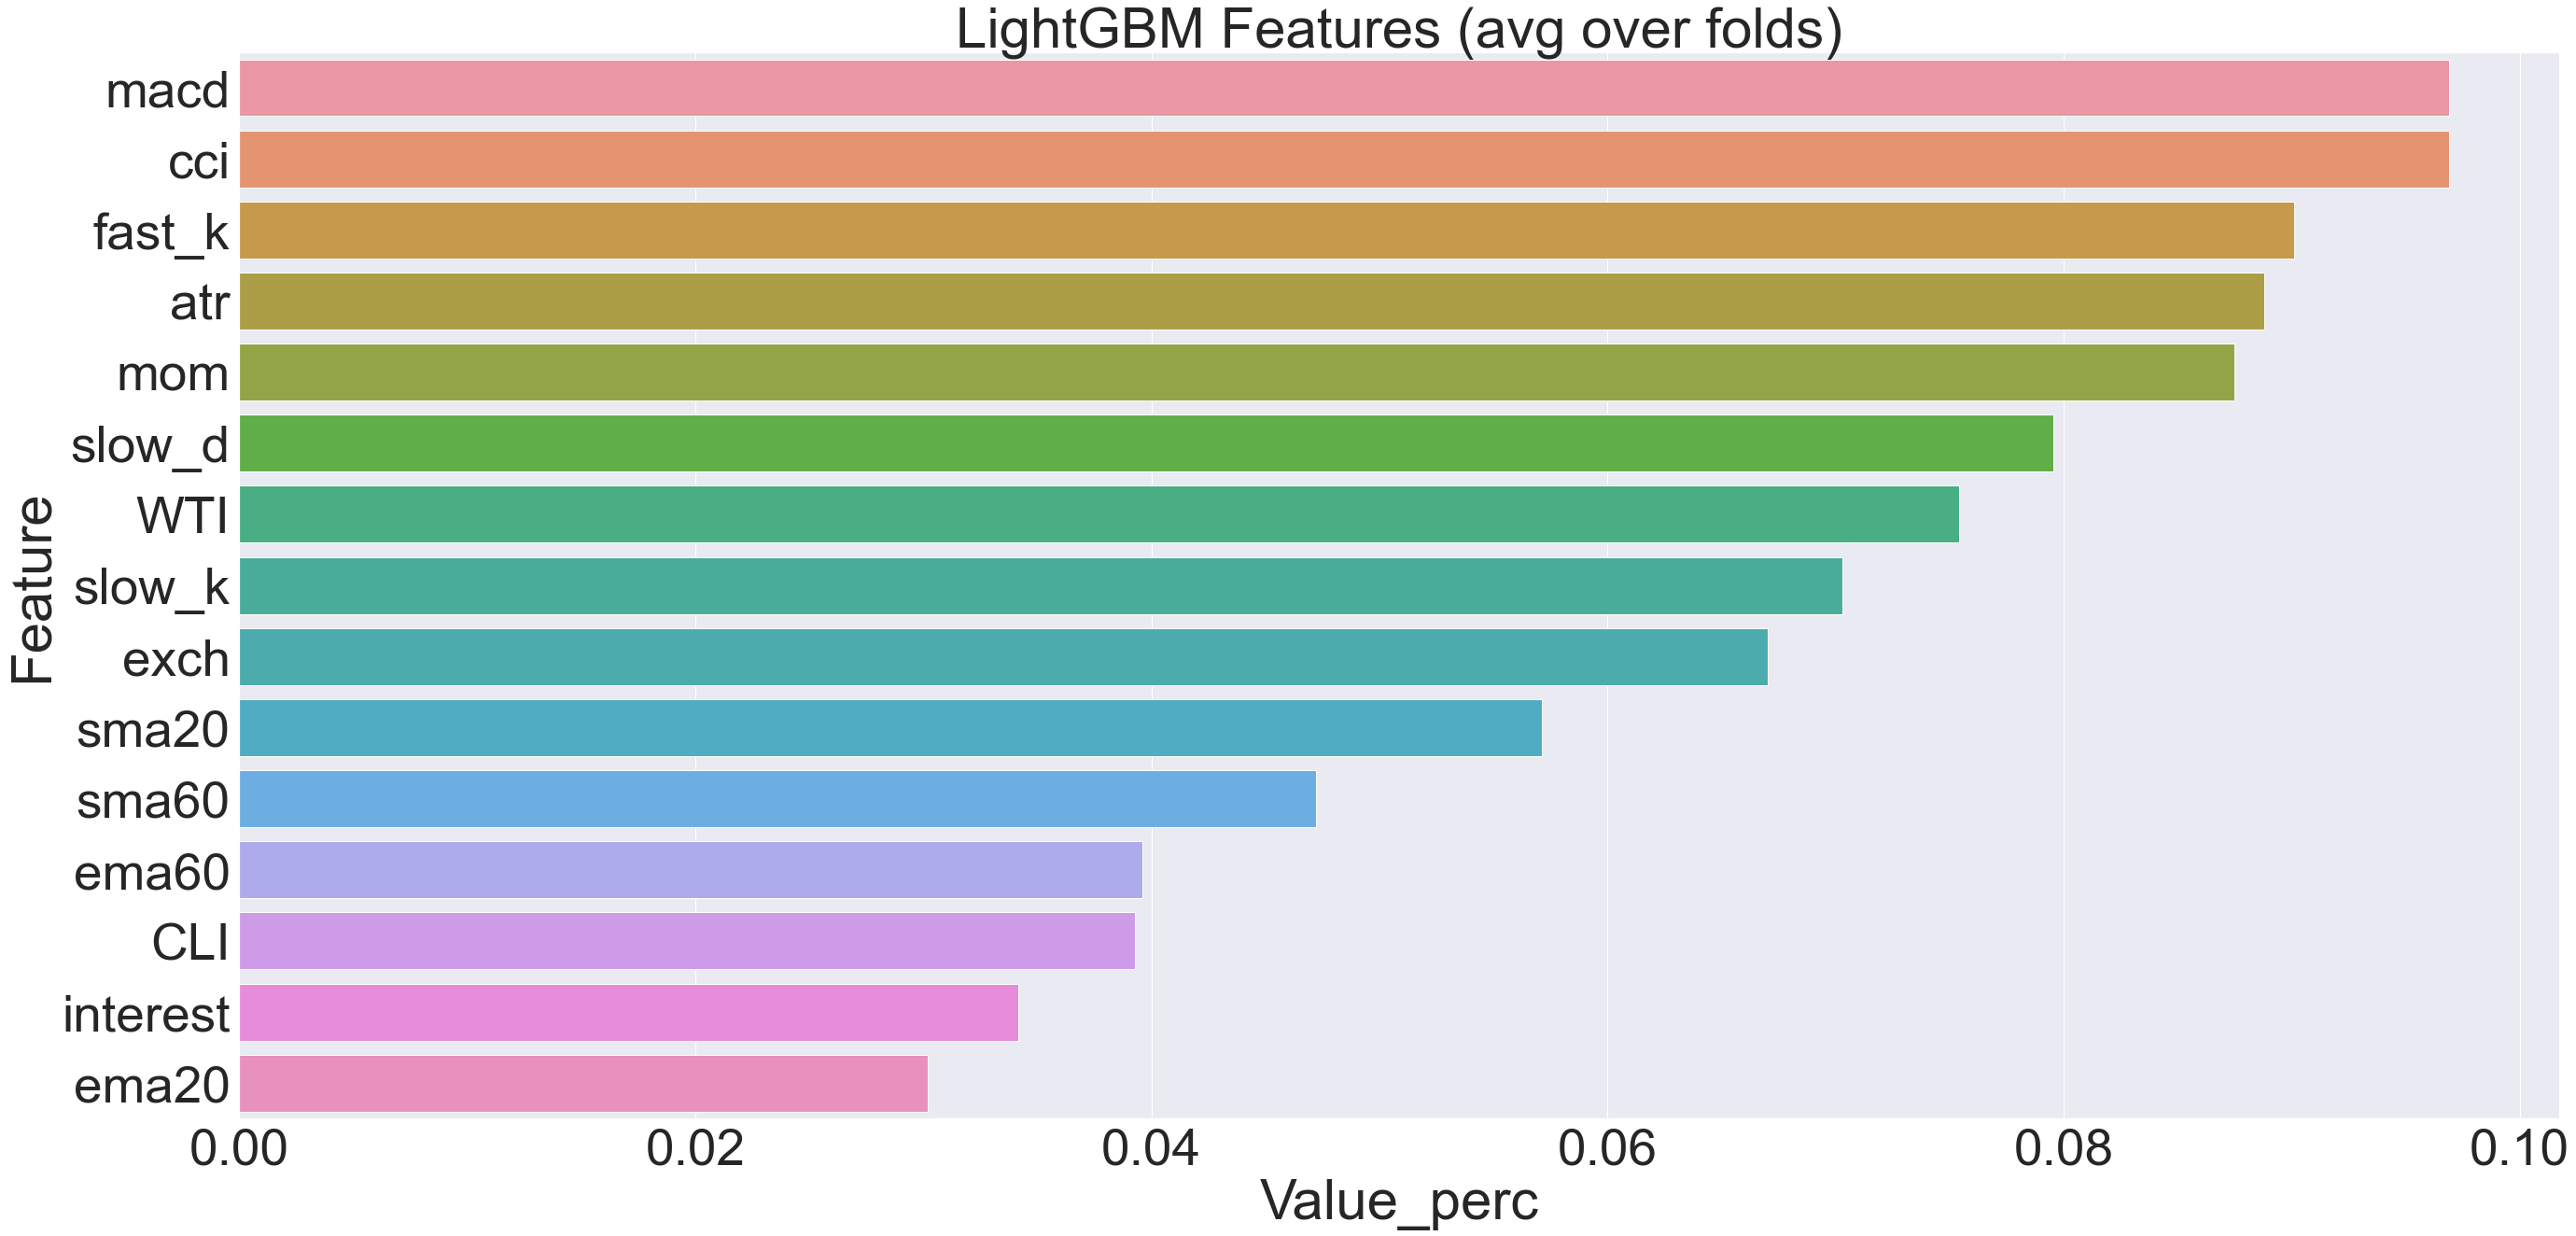

In [82]:
# Feature Importance plot
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(x="Value_perc", y="Feature", data=lgb_feature_imp_sort)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

# 예측 결과

In [ ]:
# 예측 결과 테이블 생성
testset = pd.DataFrame(y_test).reset_index()
testset.drop('index', axis=1, inplace=True)
predicted_y = pd.DataFrame({'predicted':y_pred})
predicted_table = pd.concat([testset,predicted_y], axis=1)
predicted_table.info()

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize = (8,10))
plt.subplot(2,1,1)
plt.plot(predicted_table['rsi'], color='r', label='Predicted Close')
plt.title('Predicted RSI')

sns.set(font_scale = 1)
plt.figure(figsize = (8,10))
plt.subplot(2,1,2)
plt.plot(predicted_table['predicted'], color='g', label='Actual Close')
plt.title('Actual RSI')

In [103]:
predicted_table

,rsi,predicted,rsi_2,predicted_2
0,0.292706,0.333884,NaN,NaN
1,0.256410,0.490981,NaN,NaN
2,0.355009,0.473436,NaN,NaN
3,0.435829,0.524470,NaN,NaN
4,0.678191,0.797234,NaN,NaN
...,...,...,...,...
591,0.729705,0.745572,NaN,NaN
592,0.787795,0.686043,NaN,NaN
593,0.242095,0.469094,NaN,NaN
594,0.576389,0.656094,NaN,NaN


In [100]:
predicted_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rsi          596 non-null    float64
 1   predicted    596 non-null    float64
 2   rsi_2        0 non-null      float64
 3   predicted_2  0 non-null      float64
dtypes: float64(4)
memory usage: 18.8 KB


In [110]:
predicted_table['rsi_2'] = float('nan')
predicted_table['predicted_2'] = float('nan')

for i in range(0, len(predicted_table)):
    if predicted_table['rsi'].iloc[i] >= 0.7:
        predicted_table['rsi_2'].iloc[i] = 1
    elif predicted_table['rsi'].iloc[i] <= 0.3:
        predicted_table['rsi_2'].iloc[i] = -1
    else:
        predicted_table['rsi_2'].iloc[i] = 0

    if predicted_table['predicted'].iloc[i] >= 0.7:
        predicted_table['predicted_2'].iloc[i] = 1
    elif predicted_table['predicted'].iloc[i] <= 0.3:
        predicted_table['predicted_2'].iloc[i] = -1
    else:
        predicted_table['predicted_2'].iloc[i] = 0

In [111]:
predicted_table

,rsi,predicted,rsi_2,predicted_2
0,0.292706,0.333884,-1.0,0.0
1,0.256410,0.490981,-1.0,0.0
2,0.355009,0.473436,0.0,0.0
3,0.435829,0.524470,0.0,0.0
4,0.678191,0.797234,0.0,1.0
...,...,...,...,...
591,0.729705,0.745572,1.0,1.0
592,0.787795,0.686043,1.0,0.0
593,0.242095,0.469094,-1.0,0.0
594,0.576389,0.656094,0.0,0.0


In [114]:
(predicted_table['rsi_2'] == predicted_table['predicted_2']).sum() / len(predicted_table)

0.7533557046979866

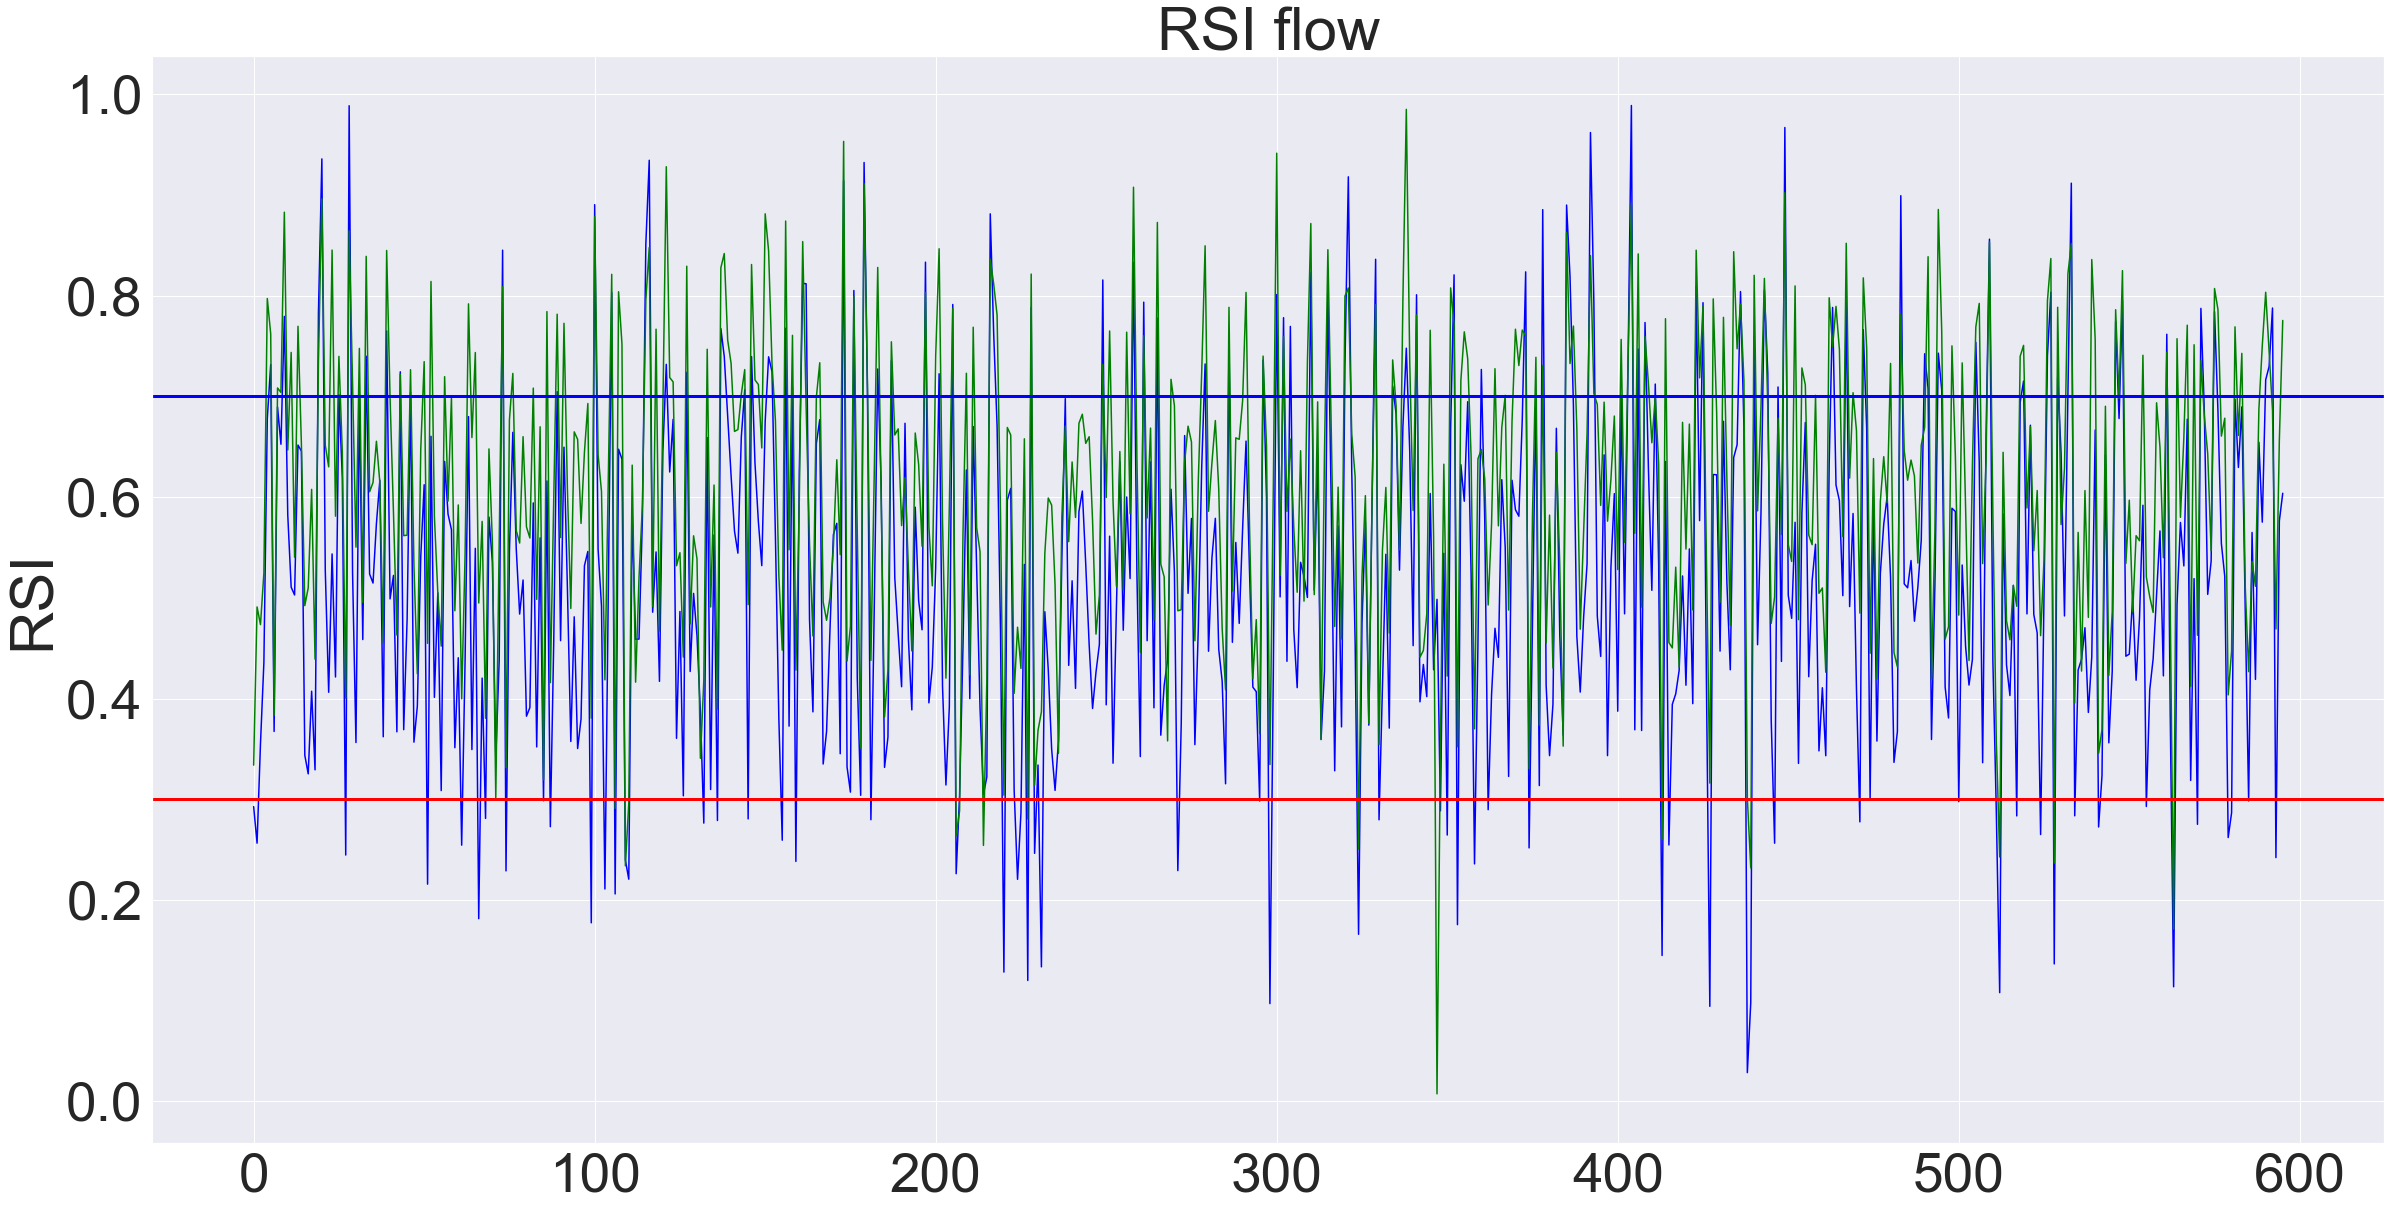

In [133]:
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
plt.plot(predicted_table.index, predicted_table['rsi'], color='blue')
plt.plot(predicted_table.index, predicted_table['predicted'], color='green')
plt.axhline(y=0.3, color='red', linewidth=3)
plt.axhline(y=0.7, color='blue', linewidth=3)

plt.title('RSI flow')
plt.ylabel('RSI')
plt.show()